## <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Studi Komparatif Model Prediksi Kolesterol dan Identifikasi Faktor Penyebab dengan Pendekatan Algoritma Gradient Boosting Machine Learning</p>

<center>Up-Skilling Team</center>
<center>Ishak Bintang Dikaputra (A11.2021.13763) | Noval Ariyanto (A11.2021.13789) | Fawwaz Atha Rohmatullah (A12.2021.06679)</center>

<center>UNIVERSITAS DIAN NUSWANTORO SEMARANG</center><br>


In [252]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

#Modeling
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedKFold
import lightgbm as lgbm
from yellowbrick.cluster import KElbowVisualizer
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
#from sklego.linear_model import LADRegression
from xgboost import XGBRegressor
from scipy.stats import yeojohnson
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from mlxtend.regressor import StackingCVRegressor
from sklearn.preprocessing import PolynomialFeatures
import optuna
from scipy.stats import pearsonr
import pickle

pio.templates.default = "none"

import warnings
warnings.filterwarnings('ignore')

palette  = ['#6499E9', '#9EDDFF', '#A6F6FF', '#BEFFF7']

### Introduction

Besides covering basic physical needs, health is one factor contributing to overall vitality and quality of life. As societies progress, understanding the intricate factors that influence health outcomes becomes paramount in devising effective strategies for promoting and maintaining well-being. 

One key indicator of health is blood cholesterol levels, particularly total cholesterol (CT). Elevated CT has been strongly linked to an increased risk of cardiovascular disease, a leading cause of mortality worldwide. Identifying the specific health factors impacting CT levels can provide crucial insights to guide public health interventions and clinical practice.

Drawing parallels to the example provided, where education is a pivotal determinant of children's prospects, our endeavor to investigate the factors influencing CT levels underscores the significance of proactive measures in safeguarding individual health outcomes. However, just as the COVID-19 pandemic disrupted educational systems globally, the health realm faces challenges, necessitating robust methodologies and interdisciplinary approaches to address evolving health concerns.

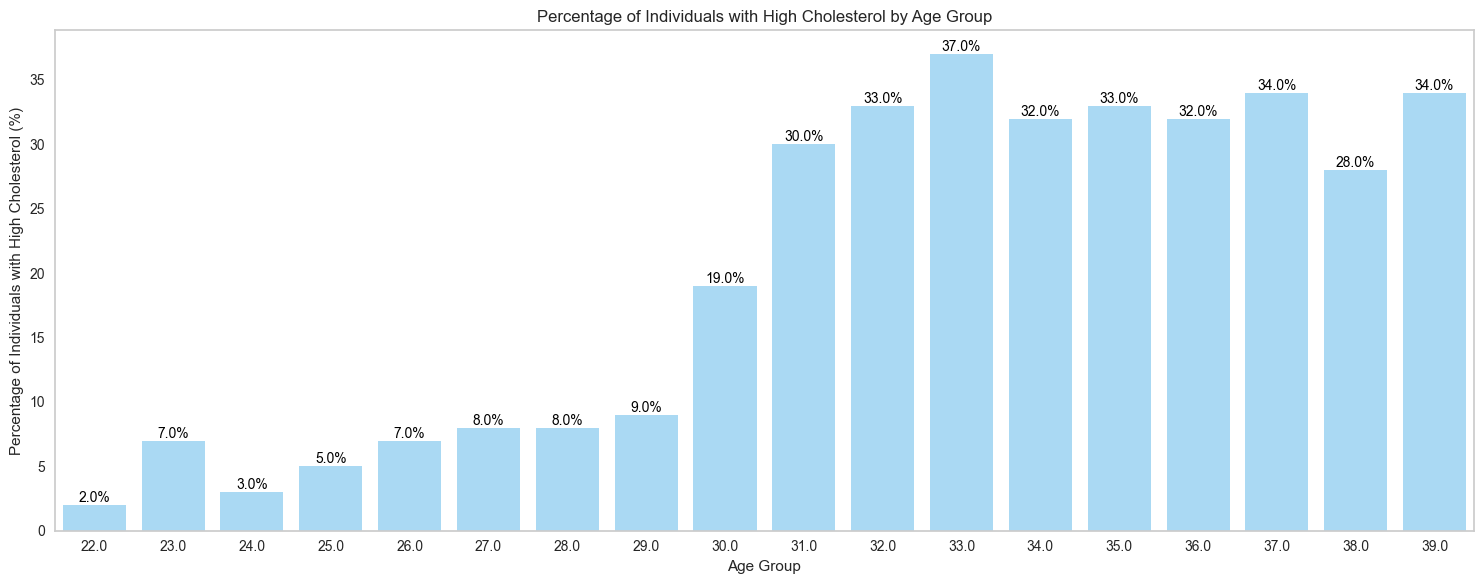

In [253]:
df = pd.read_csv('../Dataset/Data_2.csv')
x = df.copy()
age_groups = x.groupby('Usia')

counts_high_cholesterol = age_groups.apply(lambda group: (group['Cholesterol Total (mg/dL)'] >= 200).sum())
total_counts = age_groups.size()  
percentages = round((counts_high_cholesterol / total_counts) * 100)

x['Percentage_High_Cholesterol'] = x['Usia'].map(percentages)

mask = x[x['Cholesterol Total (mg/dL)'] >= 200].reset_index(drop=True)
a = mask[['Jenis Kelamin',	'Usia', 'Percentage_High_Cholesterol']].drop_duplicates()

a.Usia = a.Usia.astype('object')

plt.figure(figsize=(15,6))
ax = sns.barplot( x=a['Usia'], y=a['Percentage_High_Cholesterol'], color='lightsalmon', palette=[palette[1]])
ax.grid(False)
for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.title('Percentage of Individuals with High Cholesterol by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Percentage of Individuals with High Cholesterol (%)')

plt.tight_layout()
plt.show()

It's essential to recognize the significance of elevated cholesterol levels among young people. Despite being traditionally associated with older age groups, the increasing prevalence of high cholesterol among the younger population underscores the importance of addressing this issue early on to mitigate long-term health risks and promote healthier lifestyles.

### Methodology

The objective of this section is to find a metric to investigate the health factors most associated with total cholesterol (CT) levels. To find such health factors for Cholesterol Total, we will first explore the provided Data Kesehatan with regards to CT level. Then, we will build a metric based on the findings of the Exploratory Data Analysis (EDA) and Modeling.

### Dataset and Setup

For this competition,  we were provided a dataset by MCF-ITB. The dataset mainly contains the health data with 1339 total rows and 16 total features.

The following steps were conducted:
- statistic summary for each features
- renamed the features

In [254]:
df = pd.read_csv('../Dataset/Data_2.csv')
df.head()

,Responden,Jenis Kelamin,Usia,Tekanan darah (S),Tekanan darah (D),Tinggi badan (cm),Berat badan (kg),IMT (kg/m2),Lingkar perut (cm),Glukosa Puasa (mg/dL),Cholesterol Total (mg/dL),Trigliserida (mg/dL),Fat,Visceral Fat,Masa Kerja,Tempat lahir
0,1,M,19.0,126.0,88.0,172.5,49.5,16.53,66.0,84.0,187.0,99.0,26.4,6.0,0.97,Purworejo
1,2,M,19.0,120.0,80.0,158.0,53.6,21.50,71.0,84.0,187.0,99.0,26.4,6.0,0.60,Bogor
2,3,M,19.0,120.0,80.0,170.0,59.5,20.59,80.0,80.0,187.0,99.0,26.4,6.0,1.37,bandung
3,4,F,19.0,100.0,70.0,149.0,45.1,20.31,62.0,81.0,187.0,99.0,30.5,3.5,1.00,Jakarta
4,5,M,19.0,110.0,70.0,171.6,62.4,21.19,78.0,84.0,187.0,99.0,26.4,6.0,4.00,Teluk Betung


In [255]:
nan_count = df.isnull().sum().reset_index(name='nan')
data_types = df.dtypes.reset_index(name='dtype')

result = pd.merge(nan_count, data_types, on='index')
result

,index,nan,dtype
0,Responden,0,int64
1,Jenis Kelamin,0,object
2,Usia,0,float64
3,Tekanan darah (S),0,float64
4,Tekanan darah (D),0,float64
5,Tinggi badan (cm),0,float64
6,Berat badan (kg),0,float64
7,IMT (kg/m2),0,float64
8,Lingkar perut (cm),0,float64
9,Glukosa Puasa (mg/dL),0,float64


In [256]:
cols = ['Usia','Tekanan darah  (S)', 'Tekanan darah  (D)', 'Glukosa Puasa (mg/dL)', 'Cholesterol Total (mg/dL)', 'Trigliserida (mg/dL)', 'Visceral Fat']
for col in cols:
    df[col] = df[col].astype('int')

In [257]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Responden,1339.0,670.000000,386.680316,1.00,335.500,670.0,1004.500,1339.00
Usia,1339.0,28.597461,4.767230,19.00,25.000,28.0,31.000,39.00
Tekanan darah (S),1339.0,113.147872,10.164592,80.00,110.000,110.0,120.000,170.00
Tekanan darah (D),1339.0,74.009709,7.718752,58.00,70.000,72.0,80.000,100.00
Tinggi badan (cm),1339.0,164.940851,7.386617,138.50,160.000,165.0,170.000,187.50
Berat badan (kg),1339.0,64.620500,12.799096,38.50,55.275,62.5,71.775,139.75
IMT (kg/m2),1339.0,23.693727,4.021585,14.85,20.855,23.2,26.000,44.10
Lingkar perut (cm),1339.0,80.441972,10.688215,54.00,72.000,80.0,87.000,128.00
Glukosa Puasa (mg/dL),1339.0,84.571322,11.522057,65.00,84.000,84.0,84.000,321.00
Cholesterol Total (mg/dL),1339.0,187.995519,21.104834,103.00,187.000,187.0,187.000,308.00


In [258]:
df.describe(include=['object'])

,Jenis Kelamin,Tempat lahir
count,1339,1339
unique,2,170
top,M,Bogor
freq,1013,352


In [259]:
high_ct = df[df['Cholesterol Total (mg/dL)'] > 200]
high_ct.describe().T

,count,mean,std,min,25%,50%,75%,max
Responden,194.0,952.458763,316.270545,49.00,829.5000,1041.50,1185.7500,1338.00
Usia,194.0,32.113402,4.481109,22.00,29.0000,32.00,36.0000,39.00
Tekanan darah (S),194.0,115.015464,9.934749,80.00,110.0000,117.00,120.0000,150.00
Tekanan darah (D),194.0,75.025773,7.698621,58.00,70.0000,74.00,80.0000,100.00
Tinggi badan (cm),194.0,164.746392,8.036027,146.50,159.0000,165.00,171.0000,182.00
Berat badan (kg),194.0,67.107371,12.365145,40.10,57.8250,66.15,76.8000,99.00
IMT (kg/m2),194.0,24.633608,3.773922,17.37,22.1025,24.30,27.0150,38.39
Lingkar perut (cm),194.0,82.792784,10.777954,54.00,75.0000,83.00,90.7500,108.00
Glukosa Puasa (mg/dL),194.0,85.685567,18.022988,65.00,84.0000,84.00,84.0000,321.00
Cholesterol Total (mg/dL),194.0,224.762887,20.432512,201.00,208.2500,220.50,234.0000,308.00


In [260]:
high_ct.describe(include=['object'])

,Jenis Kelamin,Tempat lahir
count,194,194
unique,2,56
top,M,Jakarta
freq,130,55


In [261]:
new_col_names = {
    'Tekanan darah  (S)': 'Tekanan_darah_S',
    'Tekanan darah  (D)': 'Tekanan_darah_D',
    'Tinggi badan (cm)': 'Tinggi_badan',
    'Berat badan (kg)': 'Berat_badan',
    'IMT (kg/m2)': 'IMT',
    'Lingkar perut (cm)': 'Lingkar_perut',
    'Glukosa Puasa (mg/dL)': 'Glukosa_Puasa',
    'Cholesterol Total (mg/dL)': 'Cholesterol_Total',
    'Trigliserida (mg/dL)': 'Trigliserida',
    'Jenis Kelamin':'Jenis_Kelamin',
    'Visceral Fat':'Visceral_Fat',
    'Masa Kerja':'Masa_Kerja',
    'Tempat lahir':'Tempat_lahir'
}

df = df.rename(columns=new_col_names)

### Exploratory Data Analysis

In this exploratory data analysis (EDA), we aim to delve into the dataset and gain insights into various health-related parameters. By examining the distribution, relationships, and correlations within the data, we can uncover valuable information that may inform further analysis and gain valuable insights into the determinants of cholesterol levels and their implications for health outcomes.

### Unvariate Analysis

We will only try to plot the distribution for each feature that has a categorical data type

In [262]:
fig = go.Figure()
fig.add_trace(go.Violin(x=df.Usia, line_color='lightseagreen', name='Age', y0=0))


fig.update_traces(orientation='h', side='positive', meanline_visible=True)
fig.update_layout(xaxis_showgrid=False, xaxis_zeroline=False)

fig.update_layout(title='<b>Age Distribution<b>',
                  xaxis_title='Age',
                  titlefont={'size': 24,'family': 'Serif'},
                  width=800,
                  height=400,
                  template="plotly_dark",
                  showlegend=True,
                  paper_bgcolor="white",
                  plot_bgcolor='white', 
                   font=dict(
                      color ='black',
                      )
                  )
fig.show()


In [263]:
mask = df['Tempat_lahir'].value_counts().reset_index(name='count').sort_values('count', ascending=False)
total_count = mask['count'].sum()
mask['percentage'] = round((mask['count'] / total_count) * 100)
mask = mask.head(10)

fig = go.Figure()
fig.add_trace(
    go.Pie(
        labels=mask['Tempat_lahir'],
        title="Top 10 Frequent of Tempat lahir",
                  titlefont={'size':18, 'family': 'Serif',},
         values=mask['count'],
        hole=0.5,
        )
    )
fig.update_traces(
    hoverinfo='label+value',
    textinfo='label+percent',
    textfont_size=12,
    )
fig.layout.update(title="<b>Count of Tempat Lahir<b>",
                  titlefont={'size':24, 'family': 'Serif',},
                  showlegend=False, 
                  height=700, 
                  width=700, 
                  template=None, 
                 )

fig.show()

In [264]:
import plotly.express as px

colors = {'M': 'lightseagreen', 'F': 'lightsalmon'}

fig = px.histogram(df, x='Jenis_Kelamin', color='Jenis_Kelamin', color_discrete_map=colors, template="simple_white")

fig.update_layout(title="Gender Distribution", 
                  titlefont={'size':24, 'family': 'Serif'},
                  showlegend=True,
                  legend_title_text="Gender",
                  font=dict(
                      color ='black',
                      )
                 )

fig.update_traces(marker_line_color='white',
                  legendgroup='Jenis_Kelamin')

fig.show()


### Bivariate Analysis

#### Significant Difference in Blood Pressure between Genders

The analysis of the blood pressure data has revealed some important gender-based differences that provide valuable insights. Through the use of the Mann-Whitney U test, a statistical technique to compare the distributions of two independent groups, the study found statistically significant differences in both systolic and diastolic blood pressure between male and female participants. The method was chosen because both systolic and diastolic blood pressure did not follow the normal distribution. 

In [265]:
# Create subplots
fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Histogram(x=df['Tekanan_darah_S'], name='Systolic Blood Pressure', marker_color='lightseagreen'),
    row=1, col=1
)

fig.add_trace(
    go.Histogram(x=df['Tekanan_darah_D'], name='Diastolic Blood Pressure', marker_color='lightsalmon'),
    row=1, col=2
)


fig.update_xaxes(title_text='Blood Pressure', row=1, col=1)
fig.update_xaxes(title_text='Blood Pressure', row=1, col=2)

fig.update_layout(
    title='Distribution of Systolic and Diastolic Blood Pressure',
     titlefont={'size':24, 'family': 'Serif'},
    height=500, 
    width=1000,
    yaxis=dict(title='Frequency'),
    barmode='overlay'  
)

# Show plot
fig.show()

In [266]:
from scipy.stats import mannwhitneyu

systolic_male = df[df['Jenis_Kelamin'] == 'M']['Tekanan_darah_S']
systolic_female = df[df['Jenis_Kelamin'] == 'F']['Tekanan_darah_S']

diastolic_male = df[df['Jenis_Kelamin'] == 'M']['Tekanan_darah_D']
diastolic_female = df[df['Jenis_Kelamin'] == 'F']['Tekanan_darah_D']

# Perform Mann-Whitney U test for systolic blood pressure
statistic_systolic, pvalue_systolic = mannwhitneyu(systolic_male, systolic_female)

# Perform Mann-Whitney U test for diastolic blood pressure
statistic_diastolic, pvalue_diastolic = mannwhitneyu(diastolic_male, diastolic_female)

print("Mann-Whitney U Test Results for Systolic Blood Pressure:")
print("Statistic:", statistic_systolic)
print("P-value:", pvalue_systolic)

print("\nMann-Whitney U Test Results for Diastolic Blood Pressure:")
print("Statistic:", statistic_diastolic)
print("P-value:", pvalue_diastolic)

if (pvalue_systolic < 0.05) or (pvalue_diastolic < 0.05):
    print("\nThere is a significant difference in blood pressure wether Systolic Blood or Diastolic Blood between males and females.")
else:
    print("\nThere is no significant difference in blood pressure between males and females.")


Mann-Whitney U Test Results for Systolic Blood Pressure:
Statistic: 197733.5
P-value: 3.227204320549423e-08

Mann-Whitney U Test Results for Diastolic Blood Pressure:
Statistic: 203467.0
P-value: 6.356233848851536e-11

There is a significant difference in blood pressure wether Systolic Blood or Diastolic Blood between males and females.


We can see that the observed differences in blood pressure between males and females did not occur by chance - they are true, meaningful differences. Even though the analysis did not explicitly state the directionality of these differences, based on our general understanding of cardiovascular physiology, the male participants likely had higher systolic and diastolic blood pressure values than the female participants.

When assessing and managing hypertension or other blood pressure-related conditions, it is crucial to account for these gender-specific differences. Tailored screening, prevention, and treatment strategies may be necessary to effectively address the unique blood pressure profiles of men and women.

Furthermore, these blood pressure distinctions between genders could also interact with and influence other cardiovascular risk factors, such as cholesterol levels. The next logical step would be to explore how these blood pressure distinctions between men and women might relate to and impact total cholesterol (CT)

In [267]:
fig = make_subplots(rows=1, cols=2)

# Mapping colors to genders
color_map = {'M': 'lightsalmon', 'F': 'lightseagreen'}

fig.add_trace(
    go.Scatter(x=df[df['Jenis_Kelamin']=='M']['Tekanan_darah_S'], 
               y=df[df['Jenis_Kelamin']=='M']['Cholesterol_Total'], 
               mode='markers', marker=dict(color=color_map['M']), name='Male'),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=df[df['Jenis_Kelamin']=='F']['Tekanan_darah_S'], 
               y=df[df['Jenis_Kelamin']=='F']['Cholesterol_Total'], 
               mode='markers', marker=dict(color=color_map['F']), name='Female'),
    row=1, col=1
)

fig.add_trace(
    go.Scatter(x=df[df['Jenis_Kelamin']=='M']['Tekanan_darah_D'], 
               y=df[df['Jenis_Kelamin']=='M']['Cholesterol_Total'], 
               mode='markers', marker=dict(color=color_map['M']), showlegend=False),
    row=1, col=2
)

fig.add_trace(
    go.Scatter(x=df[df['Jenis_Kelamin']=='F']['Tekanan_darah_D'], 
               y=df[df['Jenis_Kelamin']=='F']['Cholesterol_Total'], 
               mode='markers', marker=dict(color=color_map['F']), showlegend=False),
    row=1, col=2
)

fig.update_xaxes(title_text="Tekanan_darah_S", showgrid=False, row=1, col=1)
fig.update_xaxes(title_text="Tekanan_darah_D", showgrid=False, row=1, col=2)
fig.update_yaxes(title_text="Cholesterol Total", row=1, col=1)

fig.update_layout(title="Cholesterol Total vs. Blood Pressure by Gender",
                   titlefont={'size':24, 'family': 'Serif'})



The plot shows that men tend to have higher blood pressure than women. However, there's no clear pattern indicating that blood pressure affects cholesterol levels. This suggests that blood pressure might not directly impact cholesterol levels.

#### Body Composition Analysis

Body composition, a fundamental aspect of human physiology, encompasses measurements such as height, weight, body mass index (BMI), and waist circumference. These metrics reflect physical attributes and serve as indicators of potential health risks.

Using data science methods has enabled researchers and healthcare workers to explore connections between different factors more deeply. This provides insights that can help develop personalized health treatments and prevention strategies.
One of these data science techniques is clustering analysis, which can identify distinct groups within a population that share common characteristics.

<Figure size 800x550 with 0 Axes>

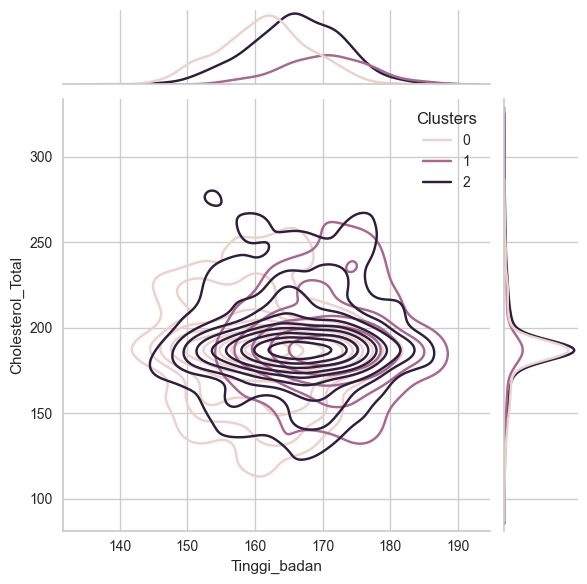

<Figure size 800x550 with 0 Axes>

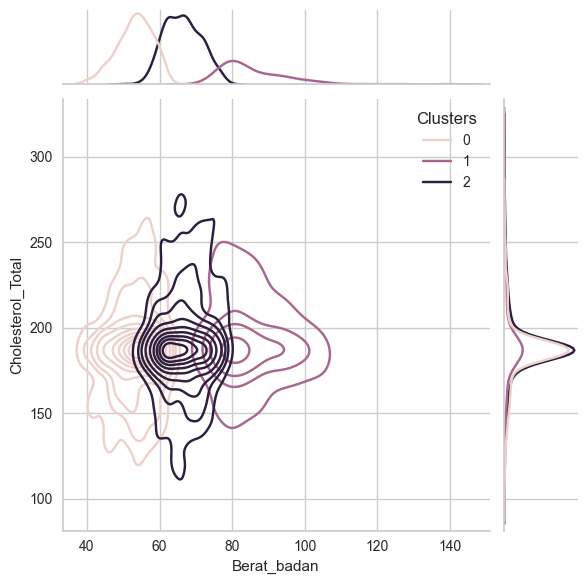

<Figure size 800x550 with 0 Axes>

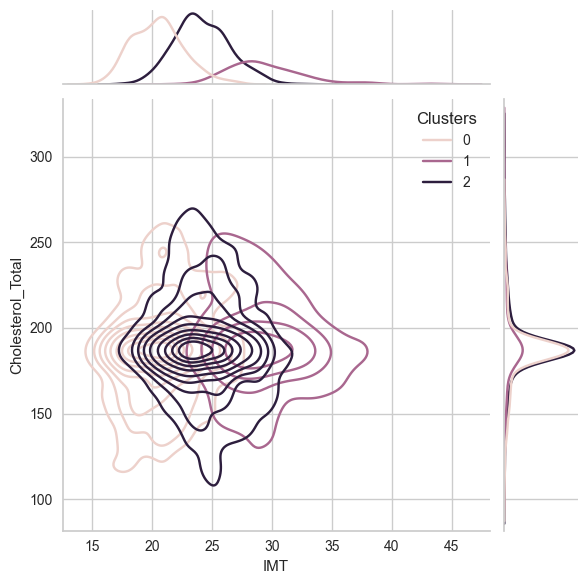

<Figure size 800x550 with 0 Axes>

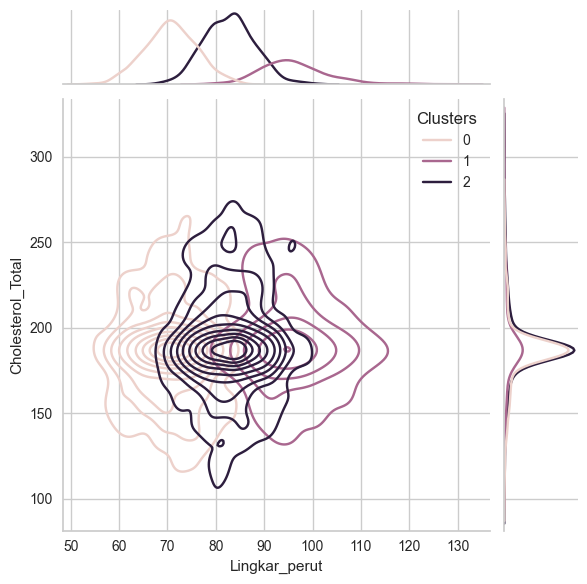

In [268]:
# For the sake of easy analysis, we will just set the num cluster to 3 
np.random.seed(42)

x = df.copy()
x = x[['Tinggi_badan','Berat_badan','IMT','Lingkar_perut']]

kmeans = KMeans(n_clusters=3)
yhat_AC = kmeans.fit_predict(x)
x['clusters'] = yhat_AC
df['Clusters'] = yhat_AC

sub = ['Tinggi_badan','Berat_badan','IMT','Lingkar_perut']

for i in sub:
    plt.figure()
    sns.jointplot(x=df[i], y=df["Cholesterol_Total"], hue =df["Clusters"], kind="kde")
    plt.show()

In [269]:
i = df[df['Cholesterol_Total'] >= 200].reset_index(drop=True)

i.groupby('Clusters')['Cholesterol_Total'].describe()

,count,mean,std,min,25%,50%,75%,max
Clusters,,,,,,,,
0,58.0,222.482759,17.240549,200.0,209.0,220.5,229.5,270.0
1,49.0,226.775510,20.996295,201.0,211.0,223.0,235.0,304.0
2,91.0,224.043956,22.205561,200.0,206.0,218.0,235.0,308.0


Cluster 0: This group includes individuals with a typical height range (146 - 187 cm) and moderate weight (50 - 78 kg). However, their body mass index (BMI) varies widely (17 - 36), indicating diverse body compositions. Despite this, their waist circumference tends to be moderate (68 - 101 cm), suggesting a balanced belly fat distribution.

Cluster 1: Individuals in this cluster have a diverse height range (138 - 180 cm) and leaner bodies, with weights typically falling in the thin category (38 - 64 kg). Most have lower BMI values (14 - 27) and narrower waist circumferences (54 - 85 cm), indicating less belly fat than other groups.

Cluster 2: This group consists of individuals with normal to taller heights (154 - 187 cm) and heavier body profiles (71 - 139 kg). They generally have higher BMI values (24 - 44) and broader waist circumferences (80 - 128 cm), suggesting a higher accumulation of belly fat.

Furthermore, it's important to note that Cluster 2, where people have a higher accumulation of belly fat, has the most individuals with high total cholesterol levels exceeding 200. However, it's not clear whether these body types directly cause higher cholesterol levels. Although Cluster 2 has more people with high cholesterol, this might be due to insufficient or biased data. So, it's tricky to say that people with a a higher accumulation of belly fat distribution are likelier to have high cholesterol levels, but in general understanding it is likely true.

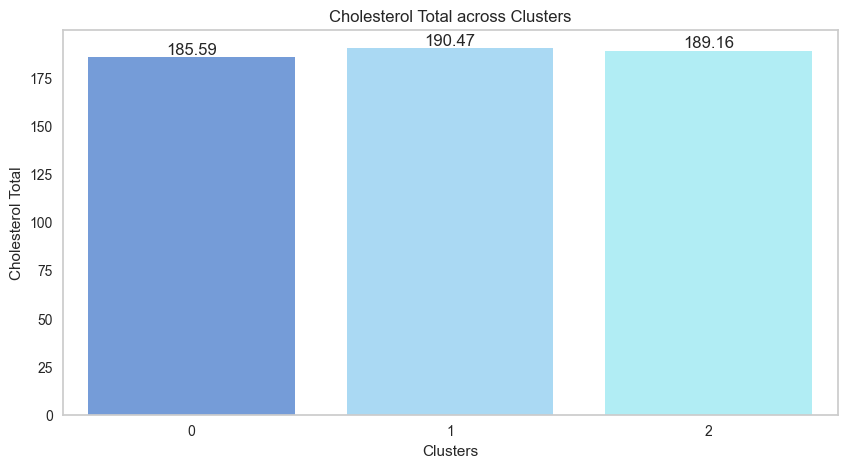

In [270]:
clus_0 = df[df['Clusters'] == 0]
clus_1 = df[df['Clusters'] == 1]
clus_2 = df[df['Clusters'] == 2]

grouped_clus_0 = clus_0.groupby('Clusters')['Cholesterol_Total'].mean()
grouped_clus_1 = clus_1.groupby('Clusters')['Cholesterol_Total'].mean()
grouped_clus_2 = clus_2.groupby('Clusters')['Cholesterol_Total'].mean()

grouped_all = pd.concat([clus_0, clus_1, clus_2], axis=0)

plt.figure(figsize=(10, 5))
ax = sns.barplot(x='Clusters', y='Cholesterol_Total', data=grouped_all, ci=None,palette=palette)
plt.title('Cholesterol Total across Clusters')
plt.xlabel('Clusters')
plt.ylabel('Cholesterol Total')
ax.grid(False)

for bar in ax.patches:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 0.05, f'{height:.2f}', ha='center', va='bottom')

plt.show()

df.drop(['Clusters'],axis=1,inplace=True)

It's interesting to note how the average cholesterol total varies across clusters. Surprisingly, cluster 1 has the highest average cholesterol total, even though it has the fewest individuals with high cholesterol levels (200 mg/dL). This might be because cluster 1 has a smaller population overall, but a higher proportion of its individuals have high cholesterol levels than other clusters.

#### Grouping Health Indicators Analysis

<Figure size 800x550 with 0 Axes>

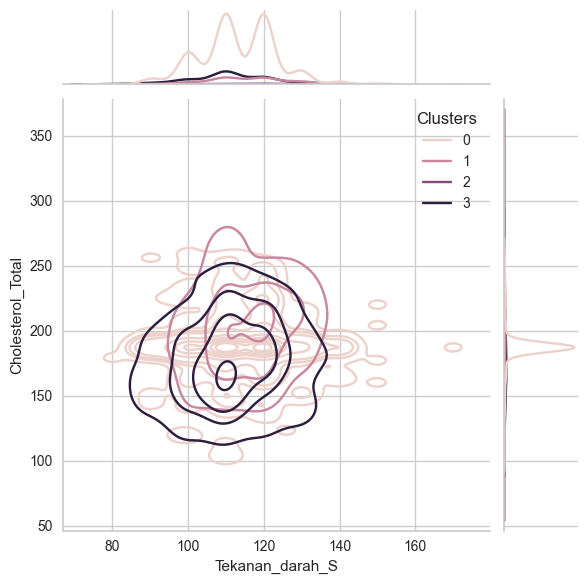

<Figure size 800x550 with 0 Axes>

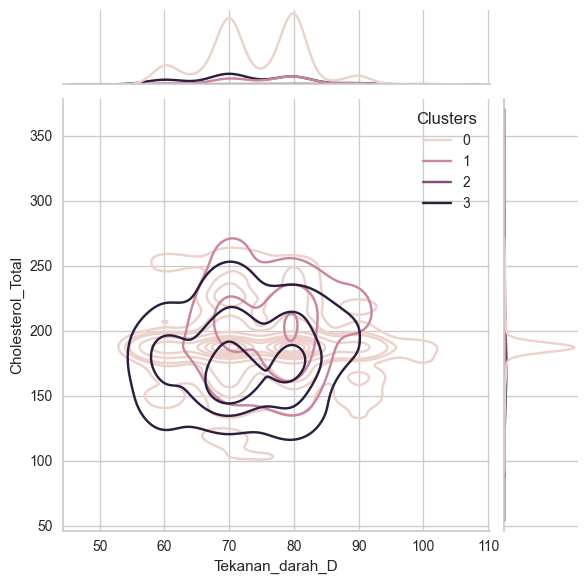

<Figure size 800x550 with 0 Axes>

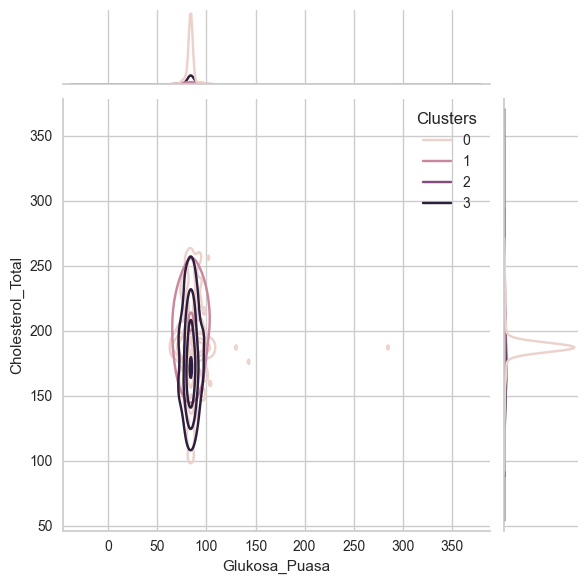

<Figure size 800x550 with 0 Axes>

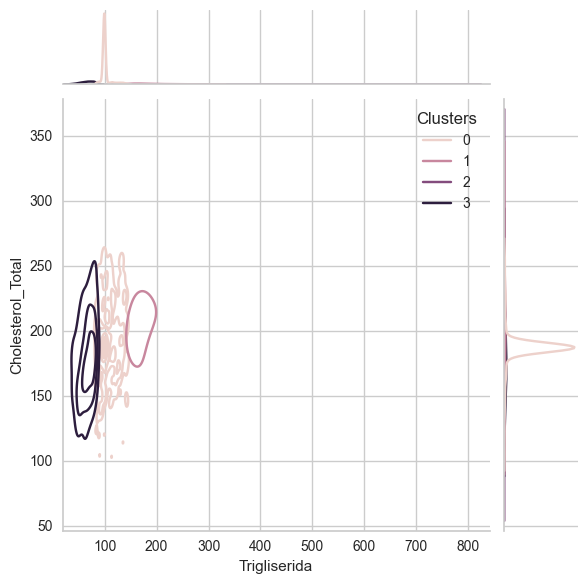

<Figure size 800x550 with 0 Axes>

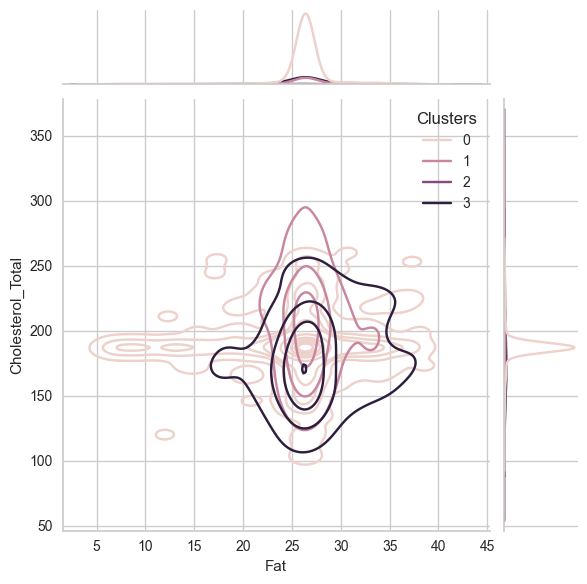

<Figure size 800x550 with 0 Axes>

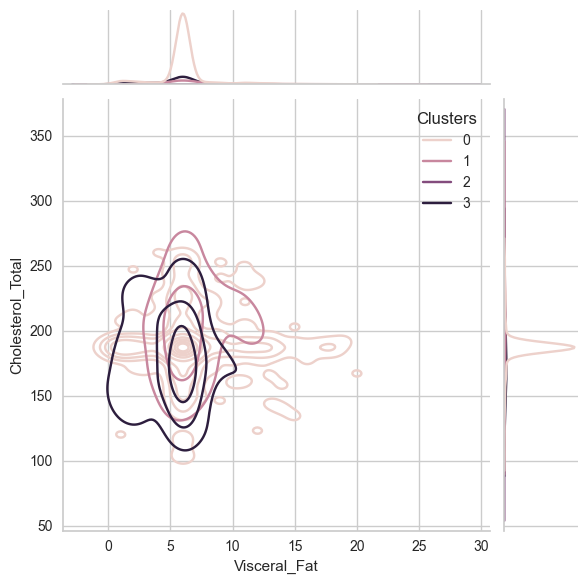

In [271]:
# For the sake of easy analysis, we will just set the num cluster to 4 
np.random.seed(42)

x = df.copy()
x = x[['Tekanan_darah_S', 'Tekanan_darah_D', 'Glukosa_Puasa', 'Trigliserida', 'Fat', 'Visceral_Fat']]

kmeans = KMeans(n_clusters=4, init='k-means++')
yhat_AC = kmeans.fit_predict(x)
x['clusters'] = yhat_AC
df['Clusters'] = yhat_AC

sub = ['Tekanan_darah_S', 'Tekanan_darah_D', 'Glukosa_Puasa', 'Trigliserida', 'Fat', 'Visceral_Fat']

for i in sub:
    plt.figure()
    sns.jointplot(x=df[i], y=df["Cholesterol_Total"], hue =df["Clusters"], kind="kde")
    plt.show()
    

In [272]:
i = df.copy()
analysis = i.groupby('Clusters')[['Cholesterol_Total', 'Tekanan_darah_S', 'Tekanan_darah_D', 'Glukosa_Puasa', 'Trigliserida', 'Fat', 'Visceral_Fat']].describe()

analysis = analysis[[('Tekanan_darah_S', 'min'), ('Tekanan_darah_S', 'count'), ('Tekanan_darah_S', 'mean'), ('Tekanan_darah_S', 'max'),
                     ('Tekanan_darah_D', 'min'), ('Tekanan_darah_D', 'count'), ('Tekanan_darah_D', 'mean'), ('Tekanan_darah_D', 'max'),
                     ('Glukosa_Puasa', 'min'), ('Glukosa_Puasa', 'count'), ('Glukosa_Puasa', 'mean'), ('Glukosa_Puasa', 'max'),
                     ('Trigliserida', 'min'), ('Trigliserida', 'count'), ('Trigliserida', 'mean'), ('Trigliserida', 'max'),
                     ('Fat', 'min'), ('Fat', 'count'), ('Fat', 'mean'), ('Fat', 'max'),
                     ('Visceral_Fat', 'min'), ('Visceral_Fat', 'count'), ('Visceral_Fat', 'mean'), ('Visceral_Fat', 'max')]]
analysis.T

df.drop('Clusters',axis=1,inplace=True)

Cluster 0: The Moderates This cluster is characterized by individuals with blood pressure within a relatively normal range, with systolic readings averaging around 113 and diastolic around 74. Their fasting glucose levels are also within a standard range, averaging 84. Notably, their triglyceride levels are on the lower end, averaging just above 100, which is considered desirable. The average fat percentage is moderate, and visceral fat levels are low, suggesting a healthier metabolic profile overall.

Cluster 1: The High-Risk Group Here, we find individuals with slightly higher blood pressure levels, but it’s their triglyceride levels that stand out, soaring to an average of 341, which is well above the normal range and indicates a significant risk factor for cholesterol issues. Their fasting glucose levels are also elevated, averaging around 95, which could signal prediabetes or metabolic syndrome. This group has the highest average visceral fat, associated with increased cardiovascular risk.

Cluster 2: The Elevated Group Individuals in this cluster have the highest average systolic blood pressure at 115 and a higher diastolic pressure. Their fasting glucose levels are slightly elevated, with an average of 86, and their triglyceride levels are notably higher than Cluster 0, averaging 178. This suggests a metabolic profile that’s heading towards potential health issues. The average visceral fat is higher than Cluster 0 but lower than Cluster 1, placing them at an intermediate risk.

Cluster 3: The Low Triglyceride Group This group presents an interesting profile with average blood pressure similar to Cluster 0, but their triglyceride levels are significantly lower, averaging 65, which is quite beneficial for cardiovascular health. Their fasting glucose levels are comparable to Cluster 0, and their average visceral fat is the lowest among all clusters, a positive sign regarding metabolic health.

Cluster 1 appears to have the highest risk profile based on higher mean values for systolic blood pressure, fasting glucose, triglycerides, and visceral fat. Clusters 0, 2, and 3 have relatively lower mean values for these parameters, indicating potentially lower cardiovascular risk profiles.

#### How do triglyceride levels correlate with total cholesterol levels

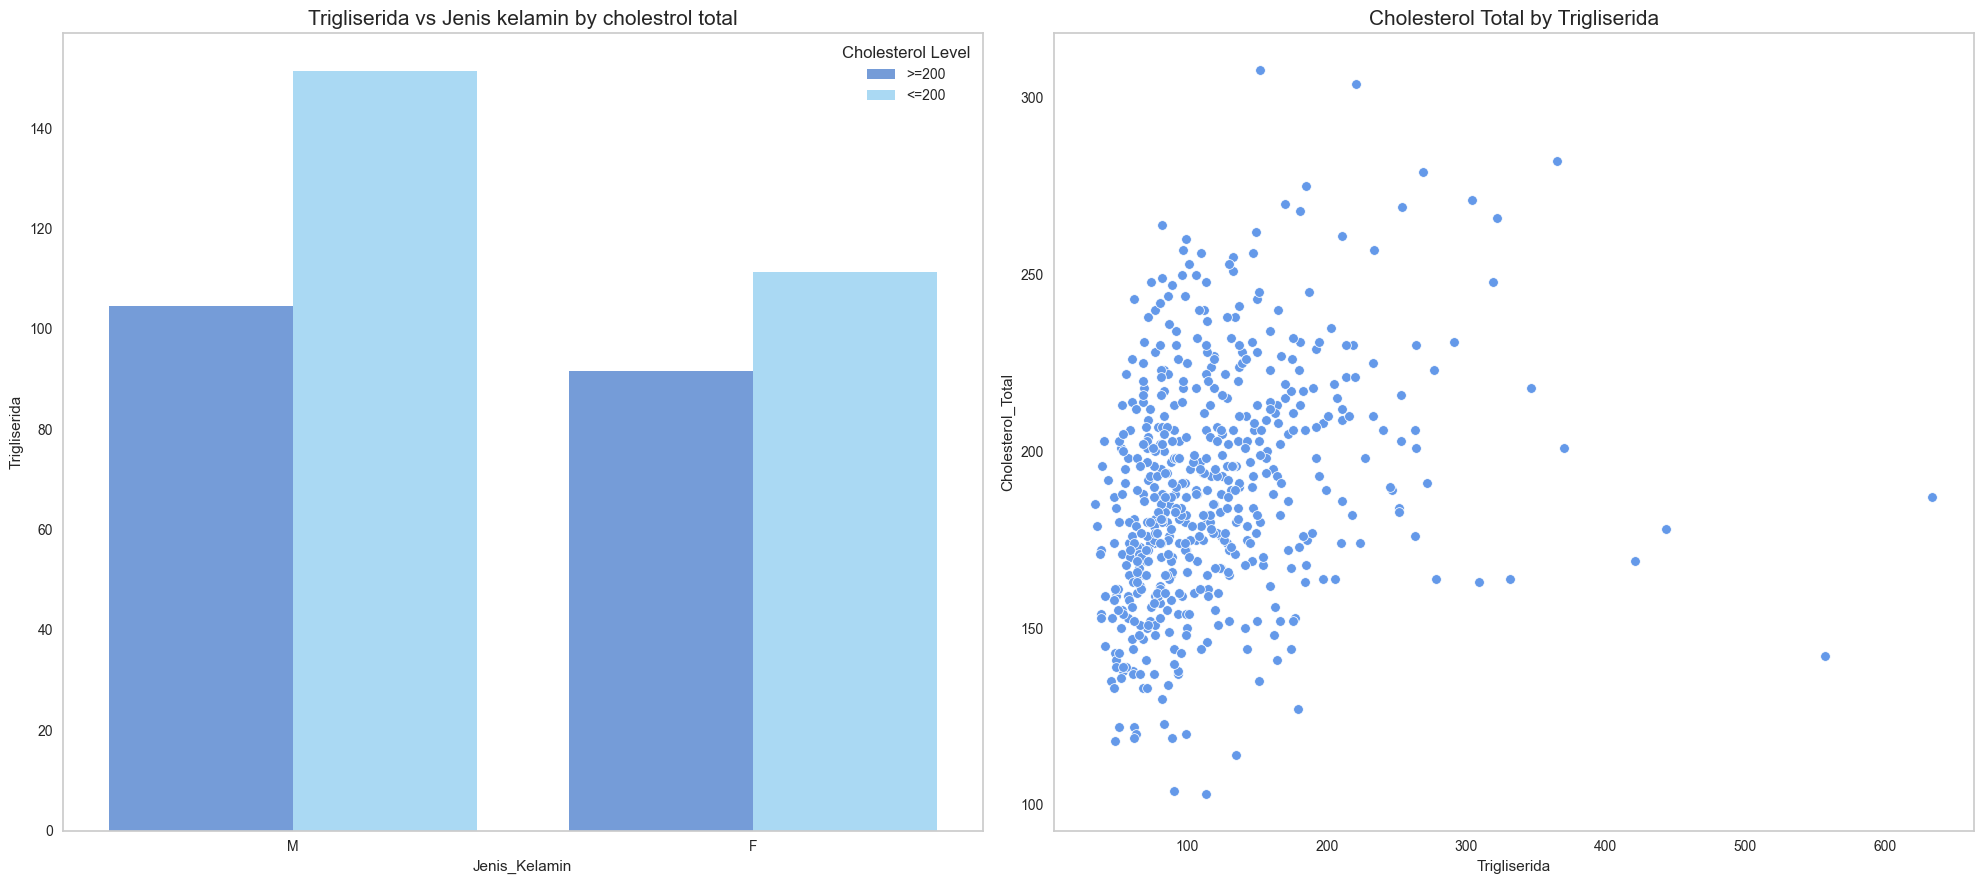

In [273]:
x = df.copy()
x['Cholesterol_Total'] = np.where(x['Cholesterol_Total'] >= 200, 1,0)

f, ax = plt.subplots(1,2,figsize=(20,9))
sns.barplot(x=x['Jenis_Kelamin'], y=x['Trigliserida'], hue=x['Cholesterol_Total'], ax=ax[0], palette=palette, ci=None)
sns.scatterplot(x=x['Trigliserida'], y=df['Cholesterol_Total'],ax=ax[1], color='#6499E9')

ax[0].set_title('Trigliserida vs Jenis kelamin by cholestrol total', size=15)
ax[1].set_title('Cholesterol Total by Trigliserida', size=15)
ax[0].grid(False)
ax[1].grid(False)

# Customize legend labels
legend_labels = {'>=200': '>=200', '<=200': '<=200'}
handles, _ = ax[0].get_legend_handles_labels()
ax[0].legend(handles, legend_labels.values(),  title='Cholesterol Level')

plt.tight_layout()
plt.show()

Triglycerides and cholesterol are both types of fat in your blood, but they’re not the same thing. Triglycerides are part of what's measured when checking total cholesterol. While they're connected, it's not always clear-cut. We can't always say that if triglycerides are high, total cholesterol will be too.

High triglyceride levels can be risky on their own. They can cause arteriosclerosis, which hardens arteries, raising the chances of heart issues like heart failure, stroke, and heart attacks.

From the plot, it appears that males are more likely to have higher levels of both triglycerides and total cholesterol compared to females.

#### Understanding Cholesterol: The Impact of Visceral Fat and Cardiovascular Risk Factors

Cardiovascular Risk Factors refer to the variables that are associated with an increased likelihood of developing cardiovascular diseases or conditions. These factors include blood pressure, fasting glucose, total cholesterol, IMT, and triglyceride levels, each playing a crucial role in assessing an individual's cardiovascular health.

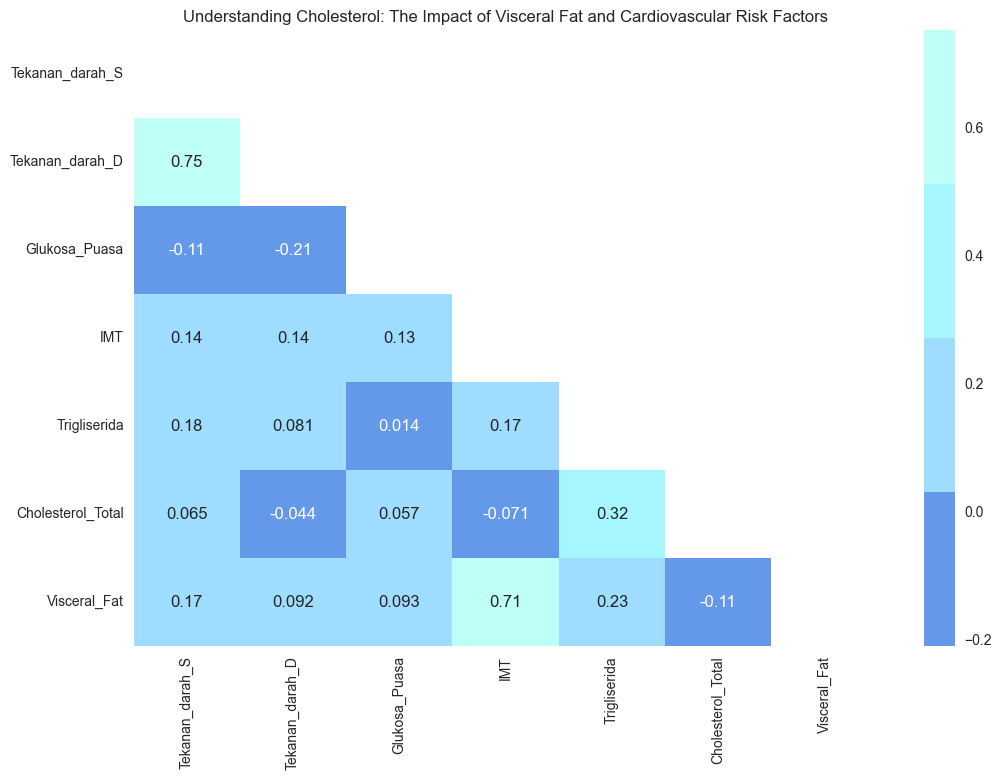

Summary Statistics for Cardiovascular Risk Factors in High-Risk Individuals:
       Tekanan_darah_S  Tekanan_darah_D  Glukosa_Puasa        IMT  \
count        89.000000        89.000000      89.000000  89.000000   
mean        119.438202        78.101124      84.550562  28.315618   
std          10.565763         6.982193       7.311279   2.935753   
min          90.000000        60.000000      68.000000  21.700000   
25%         110.000000        70.000000      84.000000  26.400000   
50%         120.000000        80.000000      84.000000  27.720000   
75%         126.000000        80.000000      84.000000  30.000000   
max         150.000000       100.000000     119.000000  38.390000   

       Trigliserida  Cholesterol_Total  
count     89.000000          89.000000  
mean     130.775281         190.415730  
std       62.601872          25.442363  
min       52.000000         123.000000  
25%       99.000000         182.000000  
50%       99.000000         187.000000  
75%      159.0

In [274]:
threshold_visceral_fat = 10  # Considered as high visceral fat

high_risk_individuals = df[df['Visceral_Fat'] >= threshold_visceral_fat]
risk_factors = ['Tekanan_darah_S', 'Tekanan_darah_D', 'Glukosa_Puasa', 'IMT', 'Trigliserida', 'Cholesterol_Total']

summary_statistics = high_risk_individuals[risk_factors].describe()
correlation_matrix = high_risk_individuals[risk_factors + ['Visceral_Fat']].corr()


f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, mask=np.triu(correlation_matrix), cmap=palette)
ax.grid(False)

ax.set_title('Understanding Cholesterol: The Impact of Visceral Fat and Cardiovascular Risk Factors')

plt.show()

print("Summary Statistics for Cardiovascular Risk Factors in High-Risk Individuals:")
print(summary_statistics)

When we looked at features related to high visceral fat levels (above 10), we found some interesting connections. Firstly, as IMT increases, so does visceral fat. This makes sense since IMT is a measure of body fat.
Secondly, we noticed a connection between triglyceride levels and visceral fat, though it wasn't as strong as the one with IMT and Fat. Surprisingly, triglyceride levels are also linked to total cholesterol.

Even though the link between visceral fat and total cholesterol isn't very strong, it's still significant. It ranks second among all the features we looked at after triglyceride levels. This means high visceral fat may play a role in cholesterol levels and our understanding of heart health, even if it's not the main factor.

#### Outliers Detection with IsolationForest

The method for detecting outliers selected is IsolationForest. This ensemble method isolates outliers by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

This method was selected since only some features followed the normal distribution, making traditional methods like IQR worse on some features, such as Trigliserida. So, isolation forest is chosen since it is a tree-based anomaly detection algorithm that works well for detecting outliers in datasets with both normal and non-normal distributions. It's also efficient for small datasets.

In [275]:
Tune = False

c = df.copy()
num_cols = [col for col in c.columns if c[col].dtype != 'object'][1:-1]

In [276]:
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_samples = trial.suggest_uniform('max_samples', 0.1, 0.9)
    contamination = trial.suggest_uniform('contamination', 0.01, 0.1)
    
    model = IsolationForest(n_estimators=n_estimators,
                            max_samples=max_samples,
                            contamination=contamination,
                            random_state=42)
    
    X_train, X_val = train_test_split(c[num_cols], test_size=0.2, random_state=42)
    model.fit(X_train)
    
    outlier_scores = model.decision_function(X_val)
    
    score = -mean_squared_error(outlier_scores, [0]*len(X_val))  # Assuming all samples are inliers
    
    return score

if Tune:
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=100)

    best_params = study.best_params
    print("Best Hyperparameters:", best_params)

In [277]:
params = {'n_estimators': 142,
 'max_samples': 0.865283998525136,
 'contamination': 0.09954498297322326}

best_isolation_forest = IsolationForest(**params, random_state=42)
best_isolation_forest.fit(c[num_cols])
outliers = best_isolation_forest.predict(c[num_cols])
c['IsOutlier'] = outliers

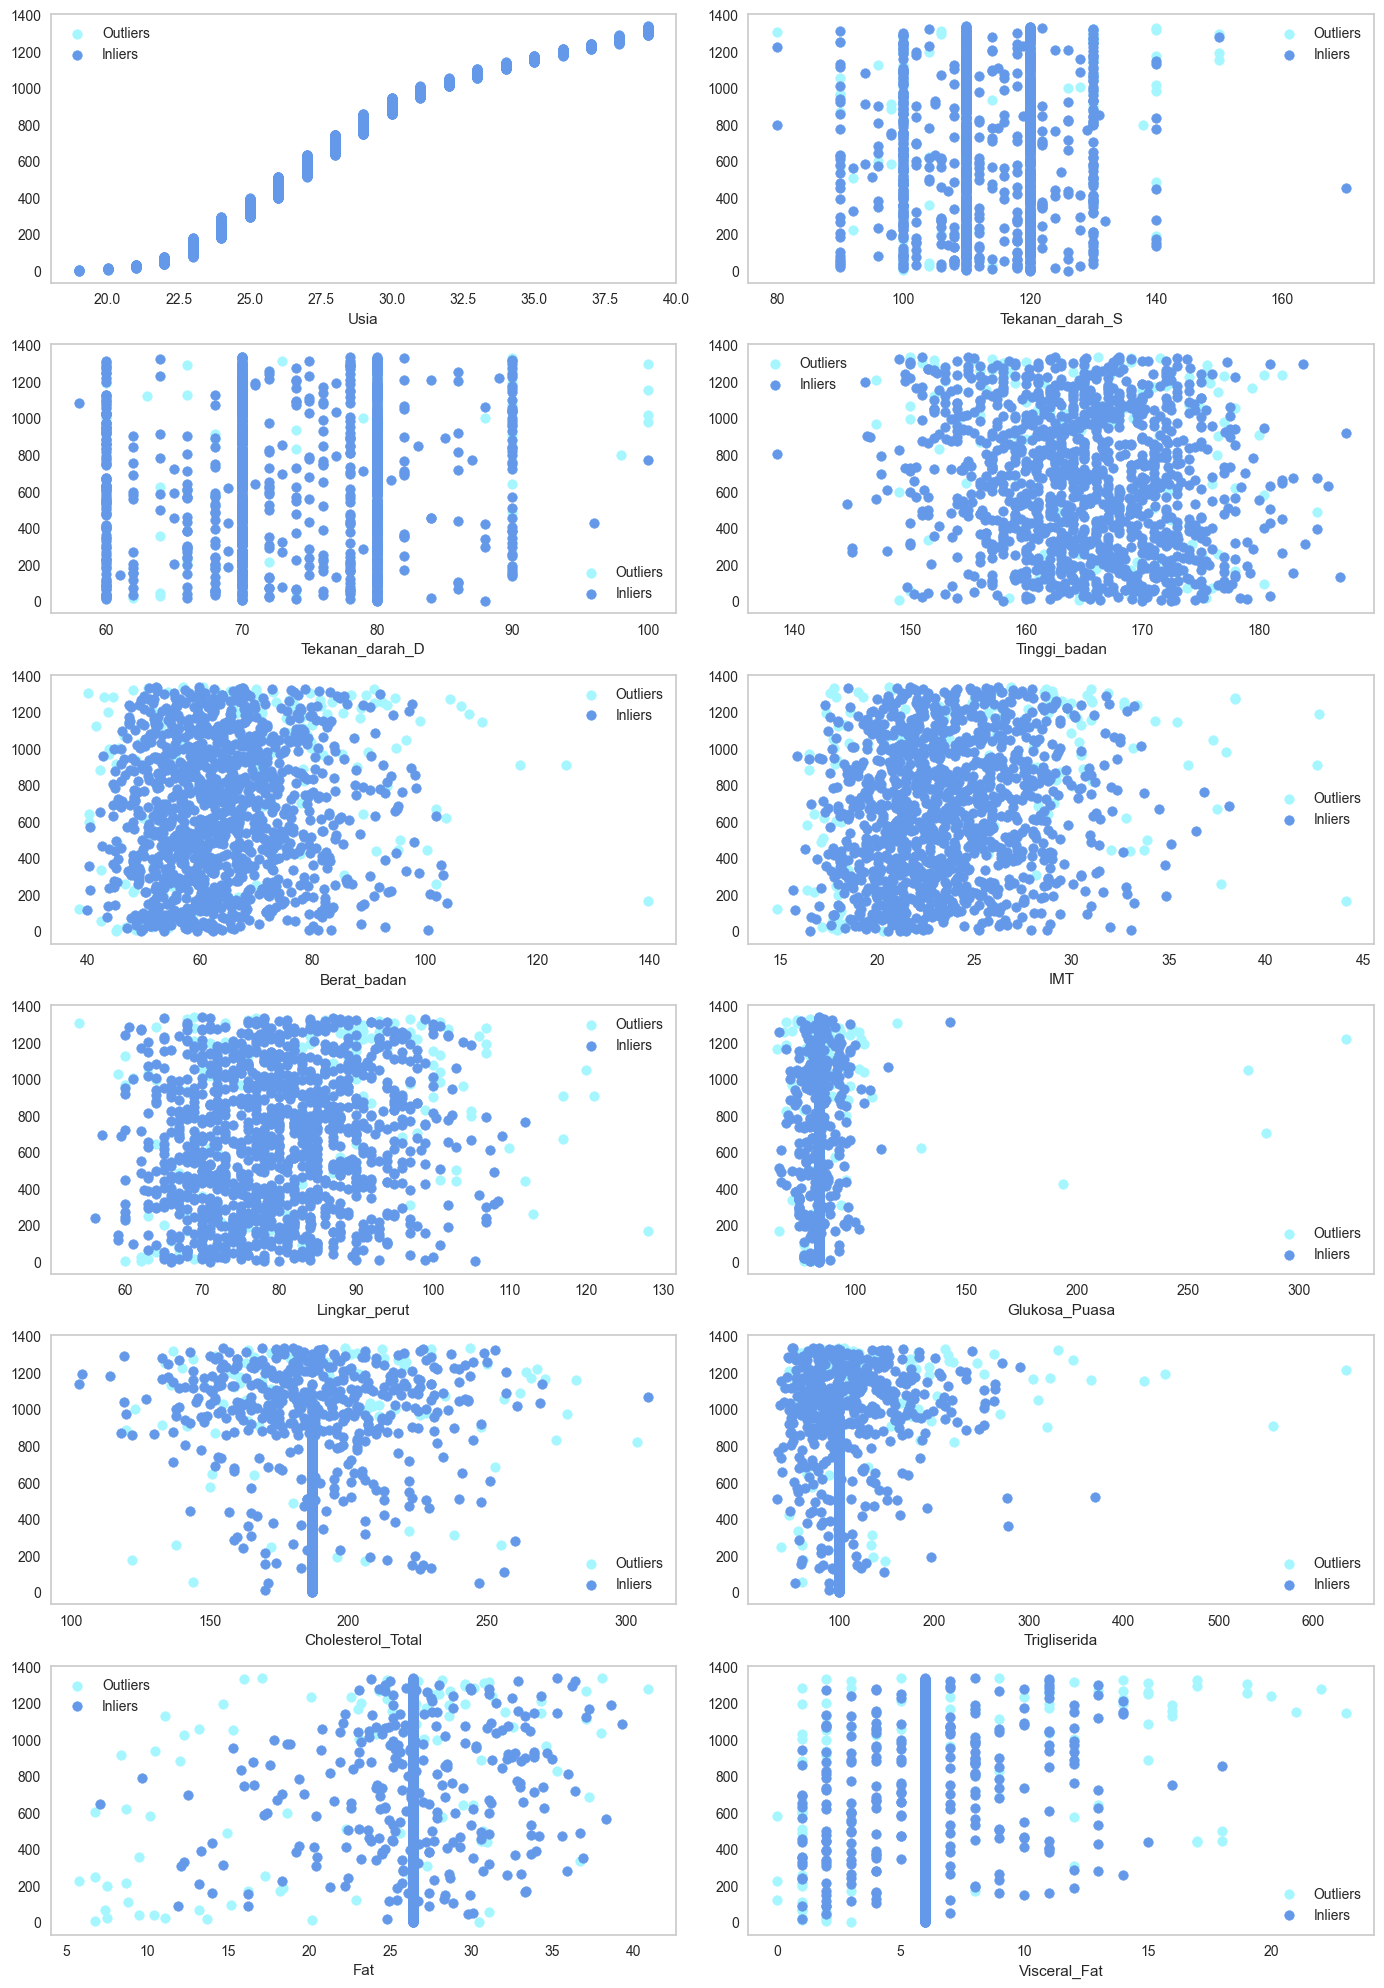

In [278]:
outliers = c[c['IsOutlier'] == -1]
inliers = c[c['IsOutlier'] == 1]

num_features = len(num_cols)
num_rows = (num_features + 1) // 2  # Calculate the number of rows needed

f, ax = plt.subplots(num_rows, 2, figsize=(14, 20))

for i, col in enumerate(num_cols):
    ax[i//2, i%2].scatter(outliers[col], outliers.index, color=palette[2], label='Outliers')
    ax[i//2, i%2].scatter(inliers[col], inliers.index, color='#6499E9', label='Inliers')
    
    # Add x-label to each subplot
    ax[i//2, i%2].set_xlabel(col)
    ax[i//2, i%2].grid(False)

# Hide the unused subplot
if num_features % 2 != 0:
    f.delaxes(ax[num_rows - 1, 1])

# Add legend to each subplot
for ax_row in ax:
    for axis in ax_row:
        axis.legend()

plt.tight_layout()
plt.show()

The outcome seems promising; the model performs reasonably well, even with highly skewed features like "Glukosa Puasa" and "Trigliserida." However, we've decided to only address some of the outliers during the modeling phase due to the limited size of the dataset. This approach helps us preserve each feature's full range of variation, avoiding potentially losing valuable information.

### Multivariate

#### Distribution for Numerical Features

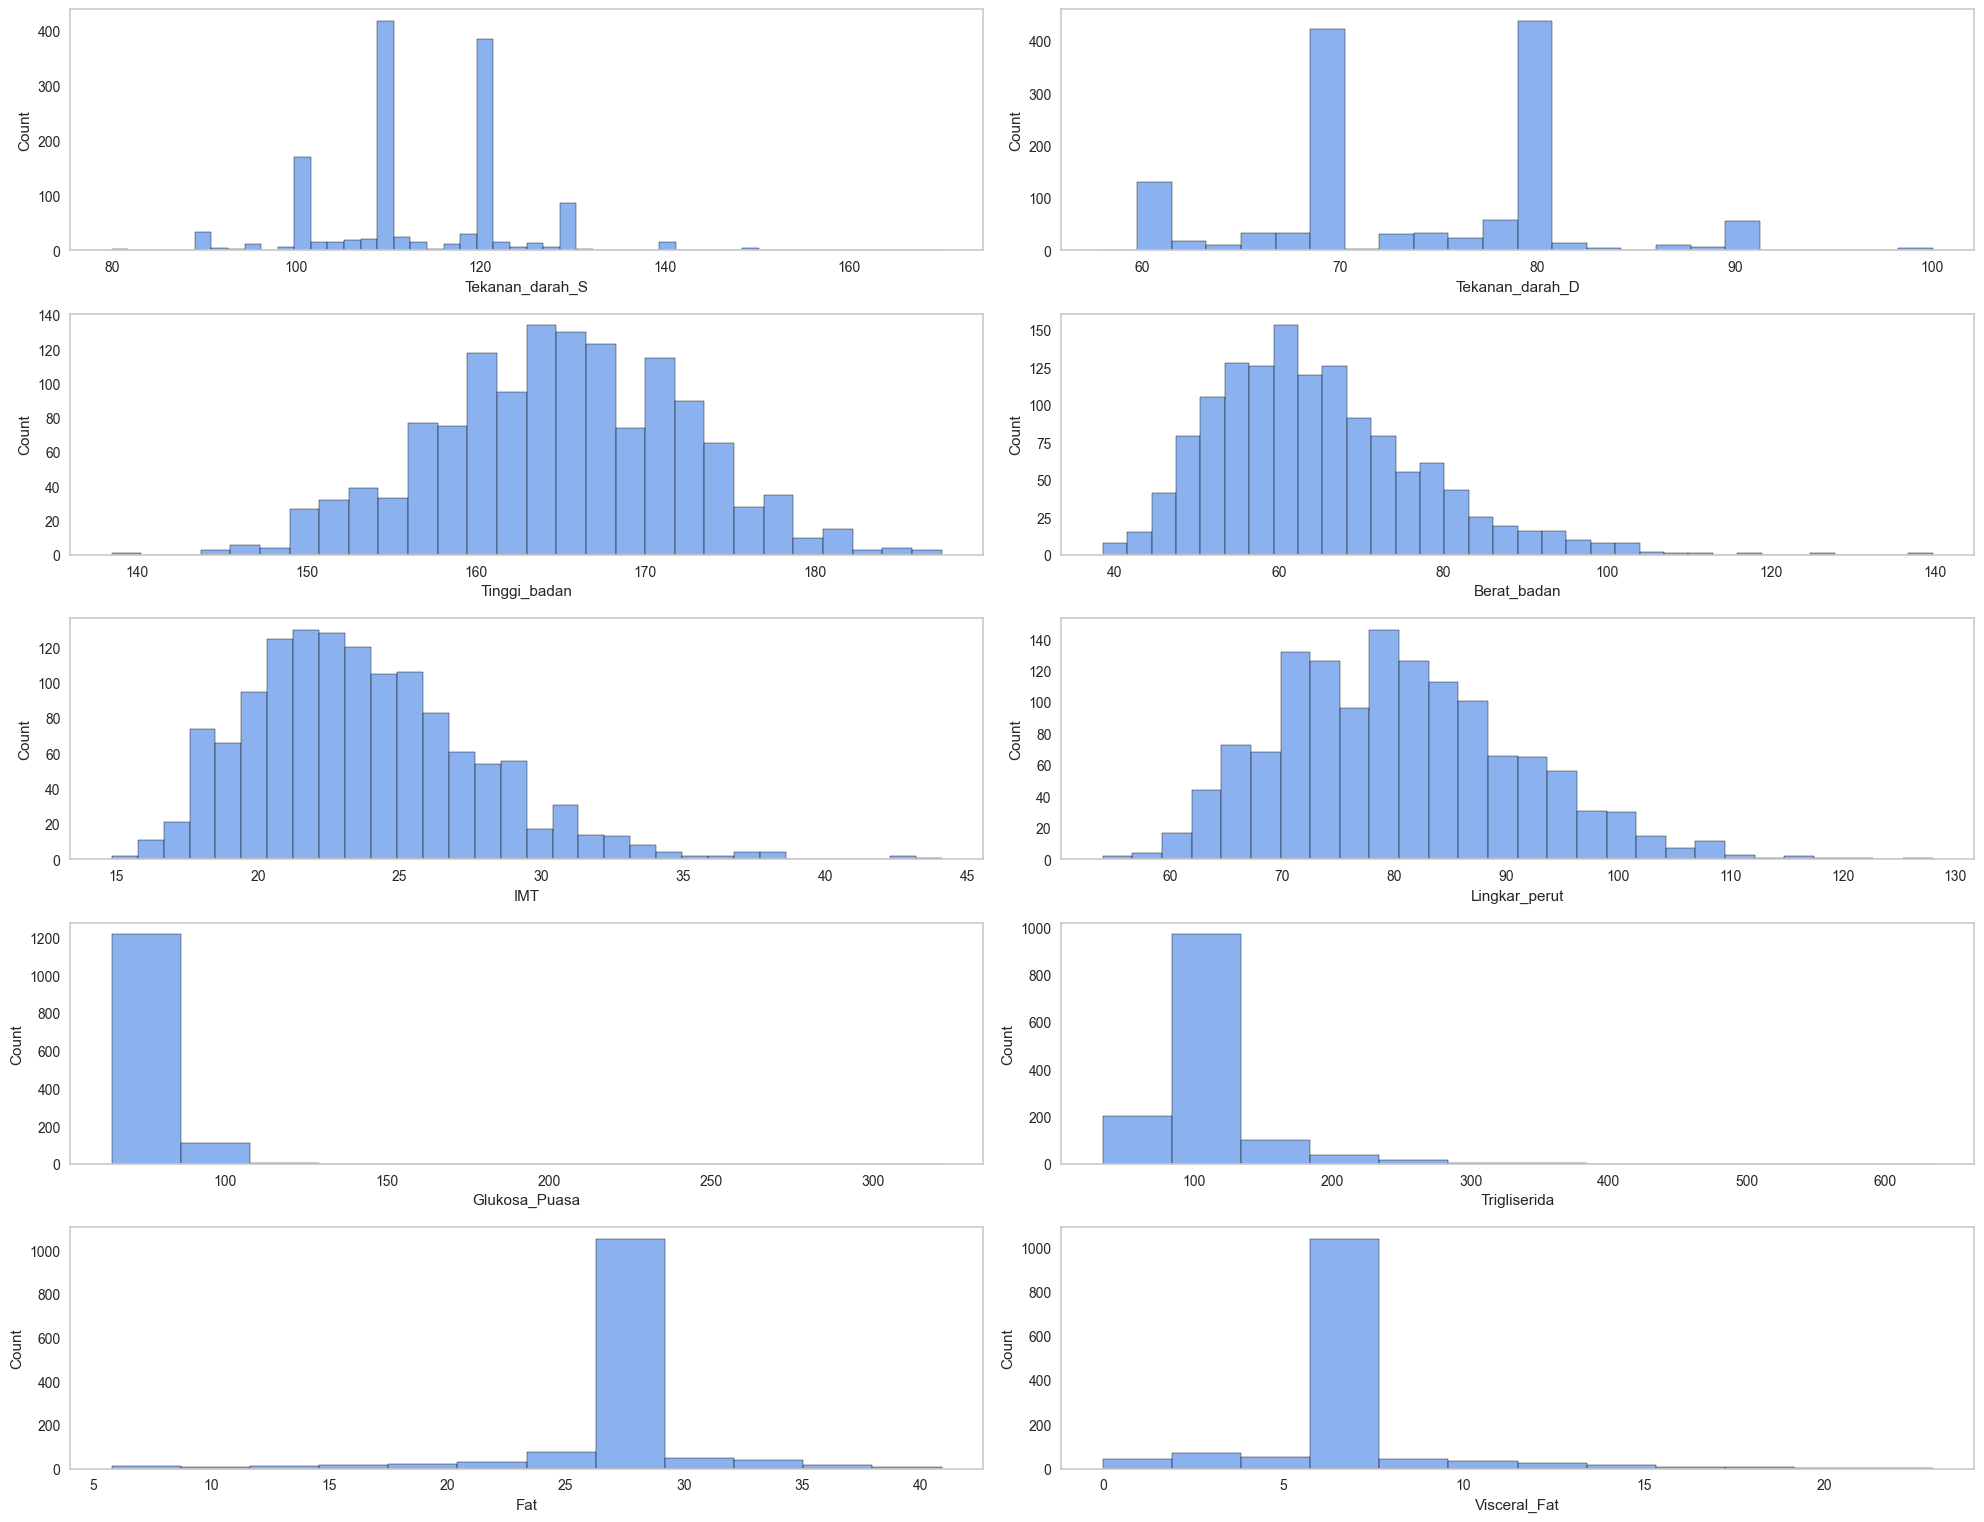

In [279]:
cols = [col for col in df.columns if df[col].dtype != 'object'][2:-1]
cols.remove('Cholesterol_Total')

f, ax = plt.subplots(6, 2, figsize=(20, 18))
for i, col in enumerate(cols):
    sns.histplot(df[col],ax=ax[i//2, i%2], color=palette[0])
    ax[i//2, i%2].grid(False)
    
for i in range(len(cols), len(ax.flatten())):
    f.delaxes(ax.flatten()[i])
    
plt.tight_layout()
plt.show()

#### Linearitas plot with Scatter

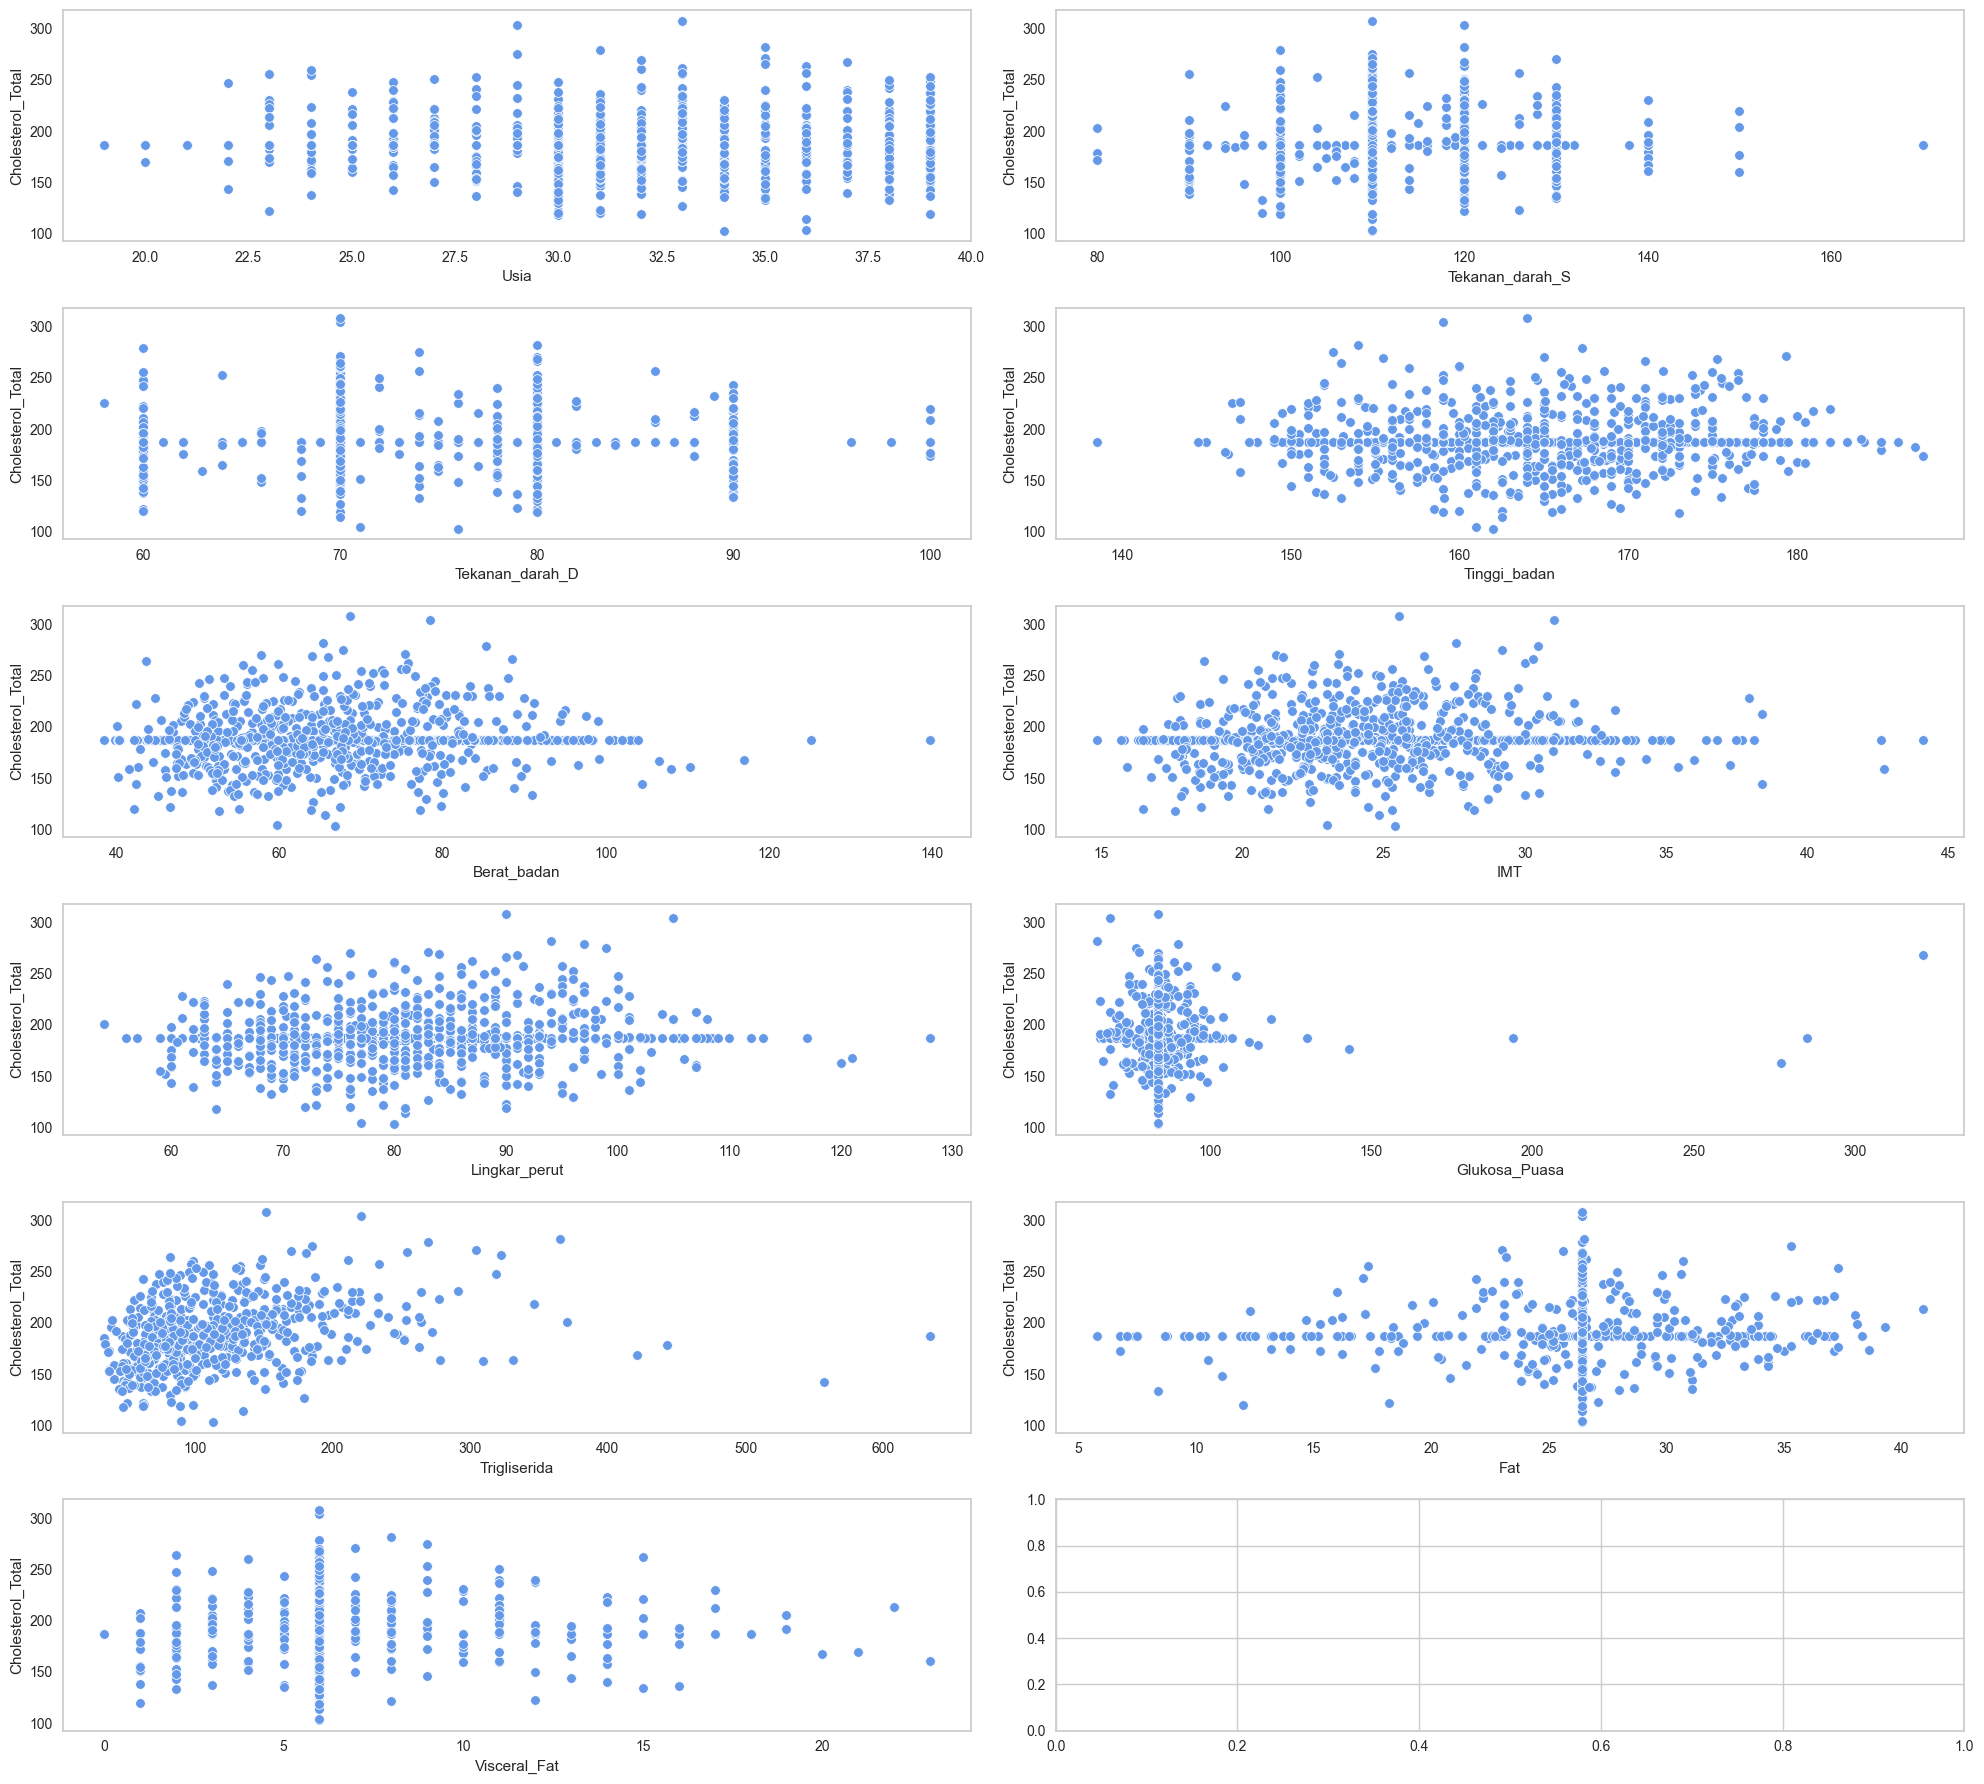

In [280]:
cols = [col for col in df.columns if df[col].dtype != 'object'][1:-1]
cols.remove('Cholesterol_Total')

f, ax = plt.subplots(6, 2, figsize=(20, 18))
for i, col in enumerate(cols):
    sns.scatterplot(data=df, x=df[col], y='Cholesterol_Total', ax=ax[i//2, i%2], color=palette[0])
    ax[i//2, i%2].grid(False)
    
plt.tight_layout()
plt.show()

#### Correlation Matrix Across Features

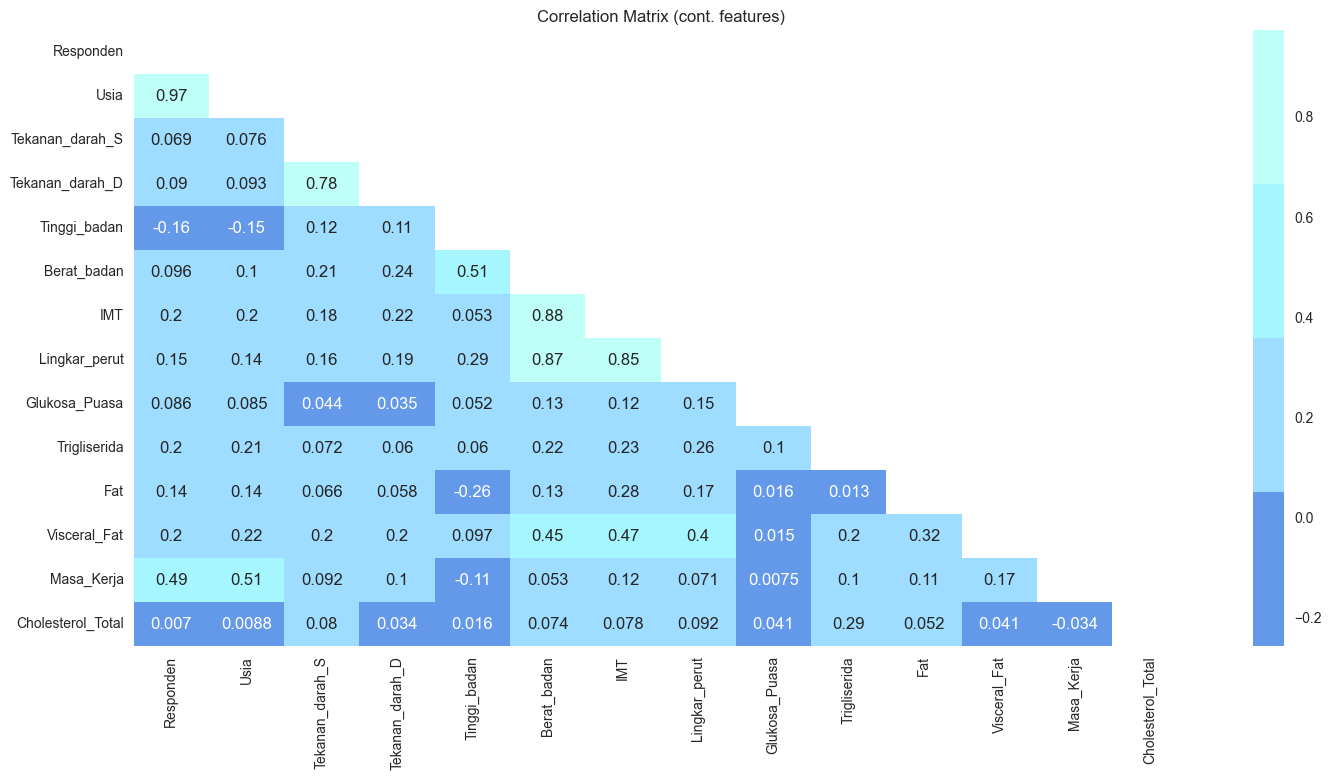

In [281]:
cols = [col for col in df.columns if df[col].dtype != 'object']
cols.remove('Cholesterol_Total')
cols.append('Cholesterol_Total')
corr = df[cols].corr()

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(17, 8))
sns.heatmap(corr, annot=True, mask=np.triu(corr), cmap=palette)
ax.grid(False)

ax.set_title('Correlation Matrix (cont. features)')

plt.show()

### Feature Engineering

The following feature engineering steps were conducted:
- group the usia using kmeans
- create new columns Age_BP_ratio_interaction, Combined_Risk_Score

In [282]:
data = df.copy()

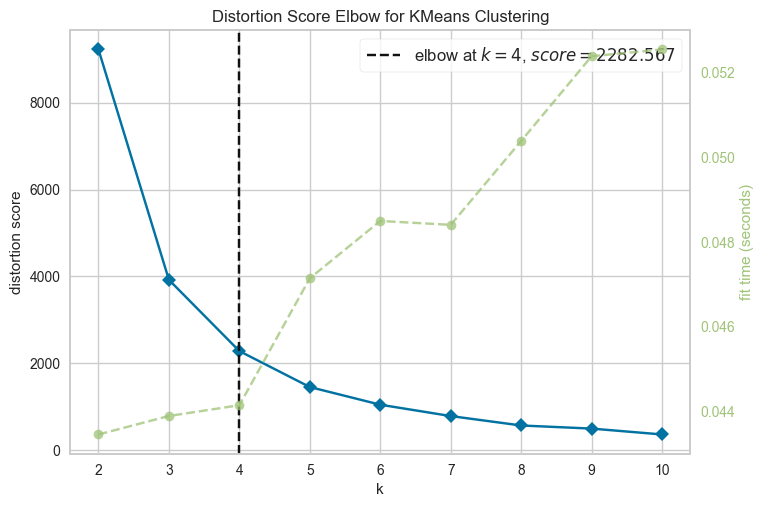

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [283]:
# perform elbow method to see the optimum cluster for usia in order to binning 
Elbow_M = KElbowVisualizer(KMeans(init='k-means++'), k=10)
Elbow_M.fit(data[['Usia']])
Elbow_M.show()

In [284]:
# binning usia with clustering
kmeans = KMeans(n_clusters=4,init='k-means++')
yhat_AC = kmeans.fit_predict(data[['Usia']])
data['usia_clusters'] = yhat_AC

In [285]:
#calculate age ratio with blood pressure
data['Age_BP_ratio_interaction'] = data['Usia'] * data['Tekanan_darah_S'] / data['Tekanan_darah_D']


weights = {'BMI': 0.4, 'Blood_Pressure': 0.3, 'Glucose_Level': 0.3}
# Calculate the combined risk score
data['Combined_Risk_Score'] = (weights['BMI'] * data['IMT'] +
                             weights['Blood_Pressure'] * (data['Tekanan_darah_S'] + data['Tekanan_darah_D']) / 2 +
                             weights['Glucose_Level'] * data['Glukosa_Puasa'])


In [286]:
data.drop(['Usia', 'Responden', 'Tempat_lahir'], axis=1, inplace=True)

#### Modeling

The following feature engineering steps were conducted:
- Perform transformation for the label using np.log1p
- Encode the gender feature
- Perform transformation for high skewed(>0.5) features 
- Perform polynomial to capture non linear relationship
- Utilize two models, lgbm and xgb, with repeated kfold
- Select a model with the lowes mae for each iteration and fold
- Metrics used MAE and RMSE

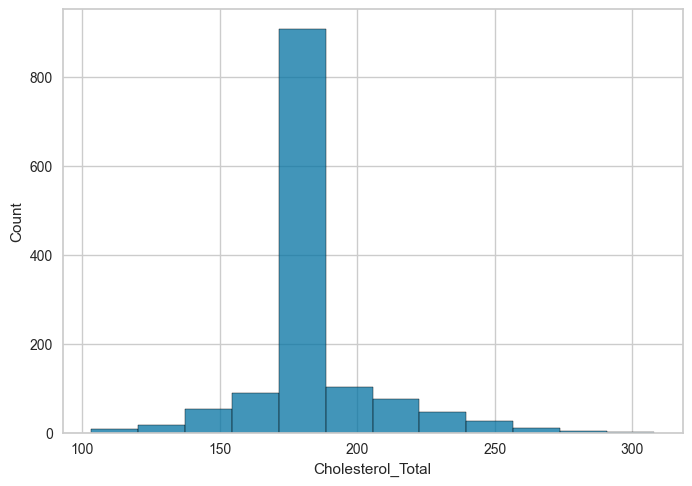

In [287]:
# checking label if its followed normal distribution or not
sns.histplot(data['Cholesterol_Total'])
plt.show()

In [288]:
# apply transformation since it is skewed
data['Cholesterol_Total'] = np.log1p(data['Cholesterol_Total'])

In [289]:
# apply labelencoder instead of onehotencoder to prevent overfitting since the data is small
label_encoder = LabelEncoder()

data['Gender'] = label_encoder.fit_transform(data['Jenis_Kelamin'])

data.drop(['Jenis_Kelamin', 'usia_clusters', 'Age_BP_ratio_interaction', 'Combined_Risk_Score'], axis=1, inplace=True)

In [290]:
data['Usia'] = df['Usia']
data.head()

,Tekanan_darah_S,Tekanan_darah_D,Tinggi_badan,Berat_badan,IMT,Lingkar_perut,Glukosa_Puasa,Cholesterol_Total,Trigliserida,Fat,Visceral_Fat,Masa_Kerja,Gender,Usia
0,126,88,172.5,49.5,16.53,66.0,84,5.236442,99,26.4,6,0.97,1,19
1,120,80,158.0,53.6,21.50,71.0,84,5.236442,99,26.4,6,0.60,1,19
2,120,80,170.0,59.5,20.59,80.0,80,5.236442,99,26.4,6,1.37,1,19
3,100,70,149.0,45.1,20.31,62.0,81,5.236442,99,30.5,3,1.00,0,19
4,110,70,171.6,62.4,21.19,78.0,84,5.236442,99,26.4,6,4.00,1,19


In [291]:
y = data['Cholesterol_Total']
x = data.drop('Cholesterol_Total', axis=1)

In [292]:
#checking high skewed (> 0.5)
skew_check = x.apply(lambda x: abs(skew(x)))
skew_check = skew_check.reset_index(name='skew')
skewness = skew_check[skew_check['skew']>0.5]
skewed_feats = skewness['index']
skewness

,index,skew
3,Berat_badan,0.926983
4,IMT,0.835478
6,Glukosa_Puasa,14.707050
7,Trigliserida,4.346800
8,Fat,1.798487
9,Visceral_Fat,2.116869
10,Masa_Kerja,1.672822
11,Gender,1.195482
12,Usia,0.562492


In [293]:
# perform transformation to get as close as possible with normal distribution
for feature in skewed_feats:
    optimal_lambda = boxcox_normmax(x[feature] + 1)
    
    x[feature] = boxcox1p(x[feature], optimal_lambda)

In [294]:
# apply polynomial since the features are not very linear with the label, and set the degree to 2 to prevent overfitting
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(x)

In [295]:
# class Model with xgb and lgbm inside
# get the model with the lowest mae for each iteration and fold
class Model():
    def __init__(self, x, y, n_splits, repeated, rdm_seed, model, params):
        self.x =x
        self.y = y
        self.n_splits =n_splits
        self.repeated = repeated
        self.rdm_seed = rdm_seed
        self.model = model
        self.params = params
        self.cv_splitter = None
        self.best_model = None
        self.best_rmse = float('inf')
        
    def split_data(self):
        cv = RepeatedKFold(n_splits=self.n_splits, n_repeats=self.repeated, random_state=self.rdm_seed)
        for fold, (train_idx, val_idx) in enumerate(cv.split(self.x, self.y)):
            X_train = self.x[train_idx]
            X_val = self.x[val_idx]
            y_train = self.y[train_idx]
            y_val = self.y[val_idx]
            yield X_train, X_val, y_train, y_val
        
    def fit(self, key):
        if key == 'xgb':
            rmse_per_fold = []
            self.cv_splitter = self.split_data()
            
            for fold, (X_train, X_val, y_train, y_val) in enumerate(self.cv_splitter):
                model = self.model(**self.params)
                model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='rmse', early_stopping_rounds=100, verbose=False)
                eval_results = model.evals_result_
                val_rmse = eval_results['validation_0']['rmse'][-1]  
                
                if val_rmse < self.best_rmse:  
                    self.best_rmse = val_rmse
                    self.best_model = model
                
                #print(f"FOLD {fold} | MAE: {val_mae:.5f}")
                rmse_per_fold.append(val_rmse)
            
            print(f"Average RMSE across all folds: {np.mean(rmse_per_fold):.5f}")
            
        elif key == 'lgb':
            rmse_per_fold = []  # Change to rmse_per_fold
            self.cv_splitter = self.split_data()

            for fold, (X_train, X_val, y_train, y_val) in enumerate(self.cv_splitter):
                model = self.model(**self.params)
                model.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric='rmse')  
                eval_results = model.evals_result_
                val_rmse = eval_results['valid_0']['rmse'][-1]  

                if val_rmse < self.best_rmse:
                    self.best_rmse = val_rmse
                    self.best_model = model

                #print(f"FOLD {fold} | RMSE: {val_rmse:.5f}")
                rmse_per_fold.append(val_rmse)

            print(f"Average RMSE across all folds: {np.mean(rmse_per_fold):.5f}")
            
        elif key == 'cat':
            rmse_per_fold = []  # Change to rmse_per_fold
            self.cv_splitter = self.split_data()
            
            for fold, (X_train, X_val, y_train, y_val) in enumerate(self.cv_splitter):
                model = self.model(**self.params, loss_function='RMSE')  # Change to 'RMSE'
                model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
                eval_results = model.get_evals_result()
                
                val_rmse = eval_results['validation']['RMSE'][-1]  # Access RMSE directly
                
                best_iteration = model.best_iteration_
                
                #print(f"FOLD {fold} | RMSE: {val_rmse:.5f}")
                rmse_per_fold.append(val_rmse)
                
                if val_rmse < self.best_rmse:  
                    self.best_rmse = val_rmse
                    self.best_model = model

            print(f"Average RMSE across all folds: {np.mean(rmse_per_fold):.5f}")
            
    def predict(self):
        self.cv_splitter = self.split_data()
        all_rmse = []
        for fold, (X_train, X_val, y_train, y_val) in enumerate(self.cv_splitter):
            X_train, X_val, y_train, y_val = X_train, X_val, y_train, y_val
    
            if self.best_model is None:
                raise ValueError("Model has not been trained yet. Call 'fit()' method first.")
            else: 
                y_preds = self.best_model.predict(X_val)
                rmse = np.sqrt(mean_squared_error(y_val, y_preds))
                all_rmse.append(rmse)
                
                train_preds = self.best_model.predict(X_train)
                train_rmse = np.sqrt(mean_squared_error(y_train, train_preds))

                #print(f"FOLD {fold} | RMSE: {rmse:.5f}")
        avg_rmse = np.mean(all_rmse)
        print(f'Average RMSE: {avg_rmse}')
        return all_rmse, y_preds, y_val
    
    def feature_importance(self):
        feature_importances = self.best_model.feature_importances_
        n_original_features = len(x.columns)
        polynomial_feature_indices = np.arange(n_original_features, self.x.shape[1])
        polynomial_feature_names = [f"Poly_{i}" for i in polynomial_feature_indices]
        all_feature_names = list(x.columns) + polynomial_feature_names
        feature_importances_df = pd.DataFrame({'feature_weight': feature_importances}, index=all_feature_names)
        feature_importances_df = feature_importances_df.sort_values('feature_weight', ascending=False)
        return feature_importances_df
    
    def inverse(self, y_preds, y_val):
        y_preds = np.expm1(y_preds)
        y_val = np.expm1(y_val)
        return y_preds, y_val
            
    def save_model_data(self, file_path):
        model_data = {
            'best_model': self.best_model,
            'best_rmse': self.best_rmse,
            'cv_splitter': list(self.cv_splitter)
        }
        with open(file_path, 'wb') as f:
            pickle.dump(model_data, f)


In [296]:
cb_params = {'iterations': 681, 'learning_rate': 0.8476535065406938, 'depth': 6, 'l2_leaf_reg': 8.57898440072371, 
             'bagging_temperature': 0.47592408905588, 'random_seed': 4897,  'verbose': False}
model_cat = Model(X_train_poly, y, 10, 3, 42, CatBoostRegressor, cb_params)

# Fit the model using RepeatedKFold
model_cat.fit('cat')
rmse, y_preds, y_val = model_cat.predict()

Average RMSE across all folds: 0.11548
Average RMSE: 0.08176760526805896


In [297]:
params = {'colsample_bytree':0.5, 'learning_rate': 0.006038145364847455, 'max_depth': 5, 
                             'n_estimators': 2200, 'reg_alpha': 0.4942069091561331, 'reg_lambda': 7.573392485219034,
                         'subsample': 0.6, 'min_child_weight': 14}


model_xgb = Model(X_train_poly, y, 10, 3, 42, XGBRegressor, params)

# Fit the model using RepeatedKFold
model_xgb.fit('xgb')
all_rmse, y_preds, y_val = model_xgb.predict()

Average RMSE across all folds: 0.10205
Average RMSE: 0.09440270808275637


In [298]:
params = {
    'learning_rate': 0.01062266495377619, 
                'n_estimators': 624, 
                'lambda_l1': 0.012569108743477874, 
                'lambda_l2': 0.05434592533064797,
                'max_depth': 11, 
                'colsample_bytree': 0.45265584786058094,
                 'verbose': -1,
                  "early_stopping_rounds": 100,
                'subsample': 0.7190473439156442, 
                'min_child_samples': 41}
model_lgbm = Model(X_train_poly, y, 10, 3, 42, lgbm.LGBMRegressor, params)

# Fit the model using RepeatedKFold
model_lgbm.fit('lgb')
all_rmse_lgb, y_preds, y_val = model_lgbm.predict()

Average RMSE across all folds: 0.10211
Average RMSE: 0.09502586615528118


##### Tunning

In [299]:
WEIGHT_TUNE_WEIGHT = True
TUNE_MODEL = False

In [300]:
def objective(trial, x, y, n_splits, repeated, rdm_seed):
    # Define the search space for hyperparameters
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        'n_estimators': 5000,
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 8),
        'device_type': 'cpu',
        'num_leaves': trial.suggest_int('num_leaves', 4, 2048),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "verbosity": -1,
        "early_stopping_rounds": 50,
    }
    
    # Create and train the model using the suggested hyperparameters
    model = lgbm.LGBMRegressor(**params)
    rmse_per_fold = []
    cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeated, random_state=rdm_seed)
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_poly, y)):
        X_train = x.iloc[train_idx]
        X_val = x.iloc[val_idx]
        y_train = y.iloc[train_idx]
        y_val = y.iloc[val_idx]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        train_pred = model.predict(X_train)
        rmse_train = np.sqrt(mean_squared_error(y_train, train_pred))
        rmse_per_fold.append(rmse)
    print(f'rmse val: {np.mean(rmse)} | train rmse {np.mean(rmse_train)}')
    # Return the mean MAE across all folds as the objective value
    return np.mean(rmse_per_fold)

if TUNE_MODEL:
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, x, y, 10, 3, 42), n_trials=500)

    # Get best hyperparameters
    best_params = study.best_params

In [301]:
params = {'learning_rate': 0.007353634265704398, 
          'verbosity':-1,
          'lambda_l1': 3.664181138122969e-05, 
          'lambda_l2': 0.397498474634019,
          'max_depth': 15, 
          'colsample_bytree': 0.6671155956864336, 
          'subsample': 0.6455796395952734, 
          'seed':0,
          'n_estimators':3000,
          'min_child_weight': 1, 
          'num_leaves': 998, 
          'min_child_samples': 11}
model_lgbm_tune = Model(X_train_poly, y, 10, 3, 42, lgbm.LGBMRegressor, params)

model_lgbm_tune.fit('lgb')
all_rmse_tune_lgb,y_preds, y_val = model_lgbm_tune.predict()
feature_importances_lgb = model_lgbm_tune.feature_importance()
y_preds_inverse_lgb , y_val_inverse_lgb = model_lgbm_tune.inverse(y_preds, y_val)

Average RMSE across all folds: 0.10923
Average RMSE: 0.023467382074479584


In [302]:
def objective(trial, x, y, n_splits, repeated, rdm_seed):
    # Define the search space for hyperparameters
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 100, 5000),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.01, 1.0),
        'subsample': trial.suggest_float('subsample', 0.01, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20)
    }
    
    # Create and train the model using the suggested hyperparameters
    model = XGBRegressor(**params)
    rmse_per_fold = []
    cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeated, random_state=rdm_seed)
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_poly, y)):
        X_train = x.iloc[train_idx]
        X_val = x.iloc[val_idx]
        y_train = y.iloc[train_idx]
        y_val = y.iloc[val_idx]
        
        model.fit(X_train, y_train, verbose=False)
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        train_pred = model.predict(X_train)
        rmse_train = np.sqrt(mean_squared_error(y_train, train_pred))
        
        rmse_per_fold.append(rmse)
    print(f'rmse val: {np.mean(rmse)} | train rmse {np.mean(rmse_train)}')
    # Return the mean MAE across all folds as the objective value
    return np.mean(rmse_per_fold)

if TUNE_MODEL:
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, x, y, 5, 3, 42), n_trials=200)

    # Get best hyperparameters
    best_params = study.best_params

In [303]:
params_xgb_tune = {
 'learning_rate': 0.008770972905815029, 'gamma': 0.010389766652732217,  'n_estimators': 5000,
 'subsample': 0.947060544440863, 'colsample_bytree': 0.5322880680354992, 'max_depth': 15, 'min_child_weight': 1,
 'lambda': 0.016447721598348113, 'alpha': 0.008150293514577826, }

model_xgb_tune = Model(X_train_poly, y, 10, 3, 42, XGBRegressor, params_xgb_tune)

model_xgb_tune.fit('xgb')
all_rmse_tune_xgb, y_preds, y_val = model_xgb_tune.predict()
feature_importances_xgb = model_xgb_tune.feature_importance()
y_preds_inverse_xgb, y_val_inverse_xgb = model_xgb_tune.inverse(y_preds, y_val)

Average RMSE across all folds: 0.10382
Average RMSE: 0.07278338667845298


In [304]:
def objective(trial, x, y, n_splits, repeated, rdm_seed):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 5000), 
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.9),
        'depth': trial.suggest_int('depth', 1, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.01, 10.0),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
         'random_seed': trial.suggest_int('random_seed', 1, 10000),
        'verbose': False,
       
    }
    
    model = CatBoostRegressor(**params)
    rmse_per_fold = []
    cv = RepeatedKFold(n_splits=n_splits, n_repeats=repeated, random_state=rdm_seed)
    for fold, (train_idx, val_idx) in enumerate(cv.split(X_train_poly, y)):
        X_train = x.iloc[train_idx]
        X_val = x.iloc[val_idx]
        y_train = y.iloc[train_idx]
        y_val = y.iloc[val_idx]
        
        model.fit(X_train, y_train, verbose=False)
        y_pred = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        train_pred = model.predict(X_train)
        rmse_train = np.sqrt(mean_squared_error(y_train, train_pred))
        
        rmse_per_fold.append(rmse)
    print(f'rmse val: {np.mean(rmse)} | train rmse {np.mean(rmse_train)}')
    # Return the mean MAE across all folds as the objective value
    return np.mean(rmse_per_fold)

if TUNE_MODEL:
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, x, y, 5, 3, 42), n_trials=200)

    # Get best hyperparameters
    best_params = study.best_params

In [305]:
cb_params = {
     'learning_rate': 0.13762007048684638,
    'depth': 5, 
    'l2_leaf_reg': 5.285199432056192,
    'bagging_temperature': 0.6029582154263095,
    'random_seed': 42,
    'verbose': False,
    'iterations':1000,
}

model_cat = Model(X_train_poly, y, 10, 3, 42, CatBoostRegressor, cb_params)

model_cat.fit('cat')
all_rmse_cat, y_preds, y_val = model_cat.predict()
y_preds_inverse_cat, y_val_inverse_cat = model_cat.inverse(y_preds, y_val)

Average RMSE across all folds: 0.10977
Average RMSE: 0.03849892651339315


In [306]:
num_folds = 5
num_repeats = 3

rkf = RepeatedKFold(n_splits=num_folds, n_repeats=num_repeats)

for fold, (train_index, val_index) in enumerate(rkf.split(x)):
    total_samples = len(train_index) + len(val_index)
    
    train_samples = len(train_index)
    val_samples = len(val_index)
    
    train_percentage = (train_samples / total_samples) * 100
    validation_percentage = (val_samples / total_samples) * 100
    
    print(f"Fold {fold + 1}:")
    print(f"Percentage of data used for training: {train_percentage:.2f}%")
    print(f"Percentage of data used for validation: {validation_percentage:.2f}%")

Fold 1:
Percentage of data used for training: 79.99%
Percentage of data used for validation: 20.01%
Fold 2:
Percentage of data used for training: 79.99%
Percentage of data used for validation: 20.01%
Fold 3:
Percentage of data used for training: 79.99%
Percentage of data used for validation: 20.01%
Fold 4:
Percentage of data used for training: 79.99%
Percentage of data used for validation: 20.01%
Fold 5:
Percentage of data used for training: 80.06%
Percentage of data used for validation: 19.94%
Fold 6:
Percentage of data used for training: 79.99%
Percentage of data used for validation: 20.01%
Fold 7:
Percentage of data used for training: 79.99%
Percentage of data used for validation: 20.01%
Fold 8:
Percentage of data used for training: 79.99%
Percentage of data used for validation: 20.01%
Fold 9:
Percentage of data used for training: 79.99%
Percentage of data used for validation: 20.01%
Fold 10:
Percentage of data used for training: 80.06%
Percentage of data used for validation: 19.94%

### Interpret Feature Importances

When we compared XGBoost (xgb) and LightGBM (lgbm) models and fine-tuned them, we found that XGB performed slightly better. So, it's a good idea to focus on understanding which features are most important in the XGB model rather than the LGBM model.

In [307]:
a = feature_importances_lgb.reset_index()
feature_importances_lgb = a[a['index'].isin(x.columns)]
feature_importances_lgb

fig = px.bar(
    x=feature_importances_lgb['feature_weight'],
    y=feature_importances_lgb['index'],
    orientation='h',
    width=700,
    height=700,
)

fig.update_layout(
    autosize=False,
    title="Feature Importances by XGB",
    font_family="San Serif",
    titlefont={'size': 20},
    margin=dict(l=150, r=100, b=100, t=100),
     xaxis_title="Feature Weight",
     yaxis_title=""
)

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False, categoryorder='total ascending')

colors = ['gray',] * 16
colors[0]  = 'lightseagreen'
colors[-1] = 'lightsalmon'
fig.update_traces(marker_color=colors, marker_line_color=None,
                   opacity=None)

fig.show()

After examining the plot, our earlier analysis linking Triglycerides with total cholesterol is confirmed: Triglycerides hold the highest importance among the features. Additionally, Age BP ratio interaction (new feature) is the second rank, followed by Masa kerja. 

In summary, the top five features, from most to least important, are:
- Triglycerides
- Age BP ratio interaction
- Berat badan
- IMT
- Combined risk score

In [308]:
pred_val = pd.DataFrame(y_preds_inverse_lgb, columns=['predicted'])
pred_val['y_val'] = y_val_inverse_lgb.values
pred_val

,predicted,y_val
0,186.383893,187.0
1,186.822764,187.0
2,187.103983,187.0
3,187.025986,187.0
4,187.635402,187.0
...,...,...
128,134.672696,134.0
129,160.775305,160.0
130,218.999609,220.0
131,186.850547,187.0


The model's predictions seem less accurate for values towards the end of the dataframe compared to the actual values. This might be because the data is skewed, especially with a lot of values around 187. Skewed data can make it harder for the model to predict well, especially when dealing with values that are different from the ones it's seen a lot, like those far from 187. While transformations may have helped mitigate the skewness, the model still struggles with predicting values at the extreme ends of the distribution

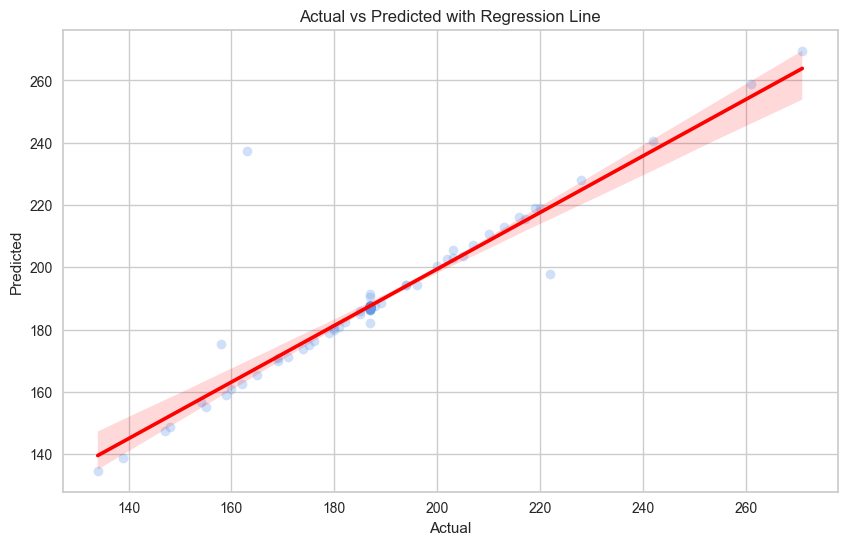

In [309]:
plt.figure(figsize=(10, 6))
color = palette[0]
sns.regplot(data=pred_val, x='y_val', y='predicted',  scatter_kws={"color": color, 'alpha': 0.3}, line_kws={"color": "red"})
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted with Regression Line')
plt.grid(True)
plt.show()

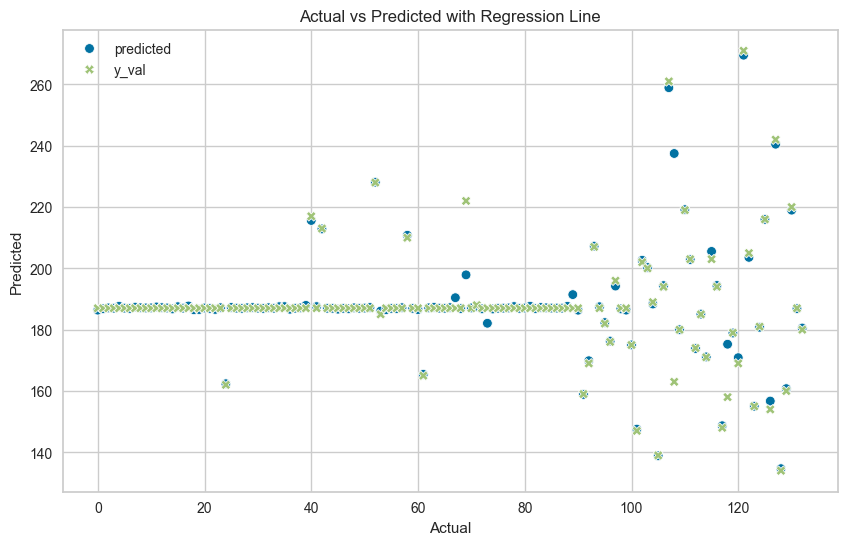

In [310]:
plt.figure(figsize=(10, 6))
sns.scatterplot(pred_val)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted with Regression Line')
plt.grid(True)
plt.show()

The data points follow the regression line fairly well, with some deviation at the higher end of the "Actual" values. This could suggest that the model performs better at predicting lower values than higher ones.

However, some data points deviate quite significantly from the regression line; for example, the model predicted 243, and the actual is 163, suggesting that the model may need to capture all the relevant factors that influence the target variable or indicate the presence of extreme outliers or the need for additional features or a more complex model to capture the underlying relationships in the data better.

Save Pickle

In [311]:
# Specify the file path where you want to save the model
file_path = '../Model/model_lgbm_tune.pkl'

# Call the save_model_data method on your model instance
model_lgbm_tune.save_model_data(file_path)
